# Detecting Anomaly in ECG Data Using AutoEncoder with PyTorch

### Introduction

The project "Detecting Anomaly in ECG Data Using AutoEncoder with PyTorch" is designed to revolutionize cardiac health monitoring by integrating advanced anomaly detection directly into patient care models. This initiative seeks to harness the power of machine learning, specifically using PyTorch, to analyze electrocardiogram (ECG) data in real-time. The project's goal is to create a system that not only tracks heart activity but also instantly alerts patients and healthcare providers of any irregularities, facilitating immediate intervention.

### Problem Statement

Cardiovascular diseases remain a leading cause of death worldwide, and early detection is crucial for effective management and treatment. Current ECG analysis methods, primarily manual and conducted in clinical settings, often lead to delays in identifying cardiac anomalies. These delays can be detrimental, especially in acute cases where every moment counts. The project addresses the need for a real-time, automated, and reliable solution that empowers patients with immediate feedback on their cardiac health, potentially saving lives through timely alerts.

### Development Method

The development of this patient-centric ECG monitoring system involves the following key steps:

1. **Data Preparation and Preprocessing**: ECG data is meticulously prepared and preprocessed for model training. This involves normalizing the data, segmenting it into readable sequences, and ensuring that it is free from noise and artifacts that could affect model accuracy.

2. **Model Architecture - Autoencoder LSTM**: The project employs an Autoencoder LSTM network architecture, realized through the PyTorch framework. This architecture is chosen for its ability to learn complex temporal patterns in ECG data. The LSTM autoencoder comprises an encoding stage to compress the input data into a condensed representation and a decoding stage to reconstruct the data from this representation.

3. **Training with Normal ECG Data**: The model is trained exclusively on datasets of normal ECG readings. This approach enables the model to learn a baseline of what constitutes a normal heart rhythm.

4. **Real-time Anomaly Detection and Alert System**: The trained model continuously analyzes incoming ECG data. The focus is on the reconstruction error: significant deviations from the learned normal patterns are flagged as anomalies. When anomalies are detected, the system immediately triggers alerts to the patient and healthcare providers, enabling swift medical response.

This proactive, real-time monitoring and alert system represents a significant leap in patient-centered cardiac care, potentially reducing the risk of late detection in cardiac events.

### Import required libraries

In [1]:
# Importing necessary libraries for TensorFlow, pandas, numpy, and matplotlib
#import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Importing the PyTorch library
import torch

# Importing additional libraries for data manipulation, visualization, and machine learning
import copy
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split

# Importing PyTorch modules for neural network implementation
from torch import nn, optim
import torch.nn.functional as F
import torch.nn as nn

# Ignoring warnings to enhance code cleanliness
import warnings
warnings.filterwarnings('ignore')

/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/elizabeth/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle

In [3]:
pwd

'/Users/elizabeth/Documents/M_CGM_Generator'

In [4]:
temp=pd.load(open('processed_sim_data/date_correctedbreakfast_week_adult#003.csv','rb'))

AttributeError: module 'pandas' has no attribute 'load'

In [4]:
#users_with_OGTT = meals.userID.unique()
def get_isi_and_bcell_function(pat_stats,info,meals,ins_var =  'Insulin_uuml' ,interpolate = True):
    users_with_OGTT = pat_stats.index.unique()
    missing = ' '
    count = 0
    
    for user in users_with_OGTT:
        info_df = info[info.userID==user]

        count_i = 0
        b_cell =[]
        for date in info_df.date.unique():
            temp = info_df[info_df.date ==date]
            try:
                temp30 = temp[temp.timepoint_mins==30]
                temp0 = temp[temp.timepoint_mins==0]
                C = list(temp30[temp30.parameter ==ins_var].value)[0]-list(temp0[temp0.parameter ==ins_var].value)[0]
                G  = list(temp30[temp30.parameter =='OGTT'].value)[0]-list(temp0[temp0.parameter =='OGTT'].value)[0]
                bcell30  =C/G
               
                pat_stats.loc[user,'Bcell30']  = bcell30
                print(user)
                print(bcell30)
                b_cell.append(bcell30)
                
            except:
                g=0
             


        count = 0
        ISI_list=[]
        for date in info_df.date.unique():
            try:
                temp = info_df[info_df.date ==date]
                temp0 = temp[temp.timepoint_mins==0]
                FPG = list(temp[temp.parameter =='FBG'].value)[0]
                #FPG = list(temp0[temp0.parameter=='OGTT'].value)[0]
                FPI  = list(temp0[temp0.parameter =='Insulin_uuml'].value)[0]

                if interpolate==False:
                    mean_insulin=np.mean(temp[temp.parameter=='Insulin_uuml'].value)
                    mean_glucose=np.mean(temp[temp.parameter=='OGTT'].value)
                else:
                    vals =list(temp[temp.parameter=='OGTT'].value)

                    vals.append((vals[1]+(vals[2]-vals[1])/3))
                    vals.append((vals[1]+2*(vals[2]-vals[1])/3))
                    mean_glucose=np.mean(vals)

                    vals =list(temp[temp.parameter=='Insulin_uuml'].value)
                    vals.append((vals[1]+(vals[2]-vals[1])/3))
                    vals.append((vals[1]+2*(vals[2]-vals[1])/3))
                    mean_insulin=np.mean(vals)

                ISI = 10000/np.sqrt((FPG*FPI)*mean_insulin*mean_glucose)
                pat_stats.loc[user,'ISI']  = ISI
                count = count+1
                #date_cgm= list(meals[meals.userID==user].Date)[0]

                #days_diff=np.abs((datetime.datetime.strptime(date, '%Y-%m-%d').date()-date_cgm).days)
                #if days_diff<60:
                ISI_list.append(ISI)
            except:  
                x=0
        if count>1:

            print(ISI_list)
    return pat_stats

In [6]:
def import_data():    
    cgm = pd.read_csv('Data/cgm.txt',  delimiter = "\t",header = 0)
    info = pd.read_csv('Data/s8.txt',  delimiter = "\t",header = 0)
    meals = pd.read_csv('Data/s5.txt',  delimiter = "\t",header = 0)
    import sqlite3
    dat = sqlite3.connect('Data/pbio.2005143.s014.db')
    query = dat.execute("SELECT * From clinical")
    cols = [column[0] for column in query.description]
    results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    
    meals.time = pd.to_datetime(meals.time)
    meals['Date'] = meals.time.dt.date
    
    cgm.DisplayTime = pd.to_datetime(cgm.DisplayTime)
    cgm['Date'] = cgm.DisplayTime.dt.date
    return cgm, info, meals, results

cgm, info, meals, pat_stats = import_data()
cgm['Time'] = cgm.DisplayTime.dt.time
subjects = cgm.subjectId.unique()
#users_with_OGTT = meals.userID.unique()
#users = pat_stats[pat_stats['diagnosis']=='diabetic'].userID.unique()
pat_stats = pat_stats.set_index('userID')
pat_stats = get_isi_and_bcell_function(pat_stats,info,meals)
pat_stats = pat_stats[pat_stats['insulin']>0]
pat_stats = pat_stats[pat_stats['Bcell30']>0]
cgm = cgm[cgm.subjectId.isin(pat_stats.index.unique())]
import numpy as np
subject_dict = {}
for subject in cgm.subjectId.unique():
    temp = cgm[cgm.subjectId==subject]
    subject_dict[subject] = {}
    subject_dict[subject]['Dates'] = temp.Date.nunique()
    subject_dict[subject]['full days']=len(temp.groupby('Date').count()[temp.groupby('Date').count().InternalTime>280])
    subject_dict[subject]['days>270']=len(temp.groupby('Date').count()[temp.groupby('Date').count().InternalTime>270])
    subject_dict[subject]['mean']=np.round(np.mean(temp.groupby('Date').count().InternalTime))
#pd.DataFrame(subject_dict).transpose()

1636-69-001
0.19000000000000003
1636-69-032
0.6236363636363638
1636-69-035
0.40625
1636-69-053
1.2378787878787878
1636-69-060
2.4799999999999995
1636-69-064
1.7571428571428573
1636-69-069
1.8122807017543858
1636-69-090
0.5885245901639345
1636-69-091
-19.375
1636-69-100
0.48723404255319147
1636-69-104
0.9587301587301588
1636-69-111
3.9846153846153842
1636-69-114
0.8200000000000001
1636-69-123
0.7126984126984127
1636-70-1003
0.8999999999999999
1636-70-1010
0.3660377358490566
2133-001
1.82
2133-006
1.2894736842105263
2133-007
0.394927536231884
2133-009
2.0304347826086953
2133-010
1.1592105263157897
2133-011
1.234
2133-012
0.8614035087719298
2133-013
0.28545454545454546
2133-015
0.4060240963855422
2133-017
1.3971014492753624
2133-018
0.4356164383561644
2133-021
0.25283018867924534
2133-022
1.1026315789473684
2133-023
0.41891891891891897
2133-024
1.3700000000000003
2133-025
0.13877551020408166
2133-026
1.1108695652173914
2133-027
0.6473118279569893
2133-028
0.2467741935483871
2133-030
0.652

In [16]:
y_list = []
labels = []
i=0
for sub in cgm.subjectId.unique():
    i+=1
    date_df = cgm[cgm.subjectId==sub]
    for date in date_df.Date.unique():
        temp = date_df[date_df.Date==date]
        temp = temp[temp.GlucoseValue !='Low']
        y = temp.GlucoseValue.values
        
        y = [int(x) for x in y]
        if len(y)>260:
            y_list.append(y[:260])
            
            
            if pat_stats.loc[sub]['diagnosis']== 'non-diabetic':
                labels.append(0)
            elif pat_stats.loc[sub]['diagnosis']== 'diabetic':
                labels.append(2)
            else:
                labels.append(1)

In [45]:
X = np.asarray(y_list)
X_new=(X-X.min())/(X.max()-X.min())

In [46]:
len(labels)
X_new=X-np.mean(X)

In [47]:
'''X = np.array(df_['CGM'][:122*93]).reshape(93,122)
Y = np.array(df_['CGM'][:122*93]).reshape(93,122)
X = X-np.mean(X)
Y = Y-np.mean(Y)
X = X/60
Y=Y/60'''

"X = np.array(df_['CGM'][:122*93]).reshape(93,122)\nY = np.array(df_['CGM'][:122*93]).reshape(93,122)\nX = X-np.mean(X)\nY = Y-np.mean(Y)\nX = X/60\nY=Y/60"

In [48]:
X = X-np.mean(X)
#Y = Y-np.mean(Y)

In [49]:
X.shape

(164, 260)

In [52]:
from sklearn.preprocessing import StandardScaler
X_new =StandardScaler().fit_transform(X_new)



In [53]:
df = pd.DataFrame(X_new)

In [54]:
X = X_new[:100]
Y=X_new[100:]

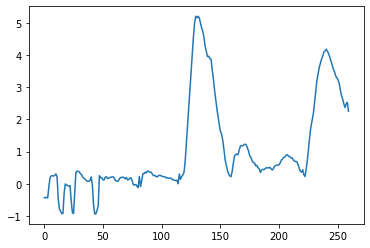

In [55]:
plt.plot(Y[0])

In [56]:
# Splitting the Dataset

# Initial Train-Validation Split:
# The dataset 'normal_df' is divided into training and validation sets.
# 15% of the data is allocated to the validation set.
# The use of 'random_state=42' ensures reproducibility.

train_df, val_df = train_test_split(
  X,
  test_size=0.15,
  random_state=42
)

# Further Splitting for Validation and Test:
# The validation set obtained in the previous step is further split into validation and test sets.
# 33% of the validation set is allocated to the test set.
# The same 'random_state=42' is used for consistency in randomization.

val_df, test_df = train_test_split(
  Y,
  test_size=0.30,
  random_state=42
)

In [57]:
# Function to Create a Dataset
def create_dataset(dfv):
    # Convert DataFrame to a list of sequences, each represented as a list of floats
    #sequences = df.astype(np.float32).to_numpy().tolist()
    sequences=dfv
    # Convert sequences to PyTorch tensors, each with shape (sequence_length, 1, num_features)
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    # Extract dimensions of the dataset
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    # Return the dataset, sequence length, and number of features
    return dataset, seq_len, n_features

In [58]:
# Create the training dataset from train_df
train_dataset, seq_len, n_features = create_dataset(train_df)

# Create the validation dataset from val_df
val_dataset, _, _ = create_dataset(val_df)

# Create the test dataset for normal cases from test_df
test_normal_dataset, _, _ = create_dataset(test_df)

# Create the test dataset for anomalous cases from anomaly_df
#test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### Implementation of LSTM-Based Autoencoder for ECG Anomaly Detection in PyTorch

In [69]:
embdi = 288/6
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=embdi):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        '''self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )'''

        self.rnn2 = nn.LSTM(
          input_size=n_features,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        #x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [70]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=embdi, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features

        '''self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        '''
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        #x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [71]:


class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=36):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))


class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=36, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [72]:
class Autoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=embdi):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [73]:
np.shape(X)

(100, 260)

### Training and Visualization of ECG Autoencoder Model in PyTorch

In [89]:
def plot_input_reconstruction(model, dataset, epoch):
    model = model.eval()

    plt.figure(figsize=(10, 5))

    # Take the first sequence from the dataset
    seq_true = dataset[random.choice([0,2,3,4,5,6])].to(device)
    seq_pred = model(seq_true)

    with torch.no_grad():
        # Squeeze the sequences to ensure they are 1-dimensional
        input_sequence = seq_true.squeeze().cpu().numpy()
        reconstruction_sequence = seq_pred.squeeze().cpu().numpy()

        # Check the shape after squeezing
        if input_sequence.ndim != 1 or reconstruction_sequence.ndim != 1:
            raise ValueError("Input and reconstruction sequences must be 1-dimensional after squeezing.")

        # Plotting the sequences
        plt.plot(input_sequence, label='Input Sequence', color='black')
        plt.plot(reconstruction_sequence, label='Reconstruction Sequence', color='red')
        plt.fill_between(range(len(input_sequence)), input_sequence, reconstruction_sequence, color='gray', alpha=0.5)

        plt.title(f'Input vs Reconstruction - Epoch {epoch}')
        plt.legend()
        plt.show()



import torch
import numpy as np
import copy

def train_model(model, train_dataset, val_dataset, n_epochs, save_path):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-4)
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    history = {'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # Save the best model weights
            print("Saving best model")
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        if epoch == 1 or epoch % 20== 0:
            plot_input_reconstruction(model, val_dataset, epoch)

    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(seq_len, n_features, int(embdi))
model = model.to(device)

In [83]:
import random

Saving best model
Epoch 1: train loss 62.90619800792021 val loss 64.40314441007726


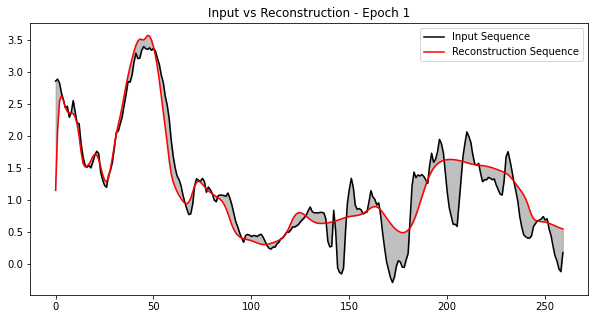

Epoch 2: train loss 65.29897182688994 val loss 74.27674257615033
Epoch 3: train loss 70.38325588001925 val loss 72.0379721697639
Epoch 4: train loss 67.59087353874655 val loss 71.30162313124713
Epoch 5: train loss 70.95897728415096 val loss 70.05328791001264
Saving best model
Epoch 6: train loss 65.81374136980843 val loss 64.11586175806382
Epoch 7: train loss 64.41706812241497 val loss 68.21349523207721
Epoch 8: train loss 63.877811476763554 val loss 67.00031639547909
Epoch 9: train loss 64.85447549258961 val loss 65.44276071436265
Saving best model
Epoch 10: train loss 62.87420124727137 val loss 61.990662653305954
Epoch 11: train loss 64.2233346378102 val loss 67.1904083925135
Epoch 12: train loss 65.4867644366096 val loss 72.13716405980728
Epoch 13: train loss 68.21519375969382 val loss 66.00227587082807
Epoch 14: train loss 64.70674391353832 val loss 69.43301342234892
Epoch 15: train loss 65.82044626123765 val loss 75.19093917397892
Epoch 16: train loss 68.75325858172248 val loss 68

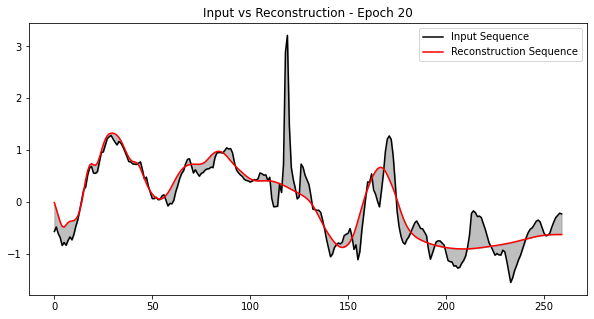

Epoch 21: train loss 66.57729927511777 val loss 63.65146073734059
Epoch 22: train loss 63.24229601691751 val loss 70.49039414349724
Epoch 23: train loss 66.65191650390625 val loss 64.84114225050982
Epoch 24: train loss 63.81095753838034 val loss 62.593883693919466
Epoch 25: train loss 64.39323512806612 val loss 64.91188325320974
Epoch 26: train loss 64.44539619894589 val loss 67.25439358879538
Epoch 27: train loss 63.66108030431411 val loss 67.81493851156796
Epoch 28: train loss 63.381559214872475 val loss 71.14309292961569
Epoch 29: train loss 63.66983424915987 val loss 64.89860299054314
Epoch 30: train loss 66.64357129265281 val loss 69.3660872739904
Epoch 31: train loss 70.31826272852281 val loss 70.15023958542767
Epoch 32: train loss 68.0393616844626 val loss 65.71410235236672
Epoch 33: train loss 66.13230265449076 val loss 66.15392868939568
Epoch 34: train loss 62.5900494519402 val loss 68.24240641874425
Epoch 35: train loss 64.26512190874885 val loss 65.64690612344181
Epoch 36: t

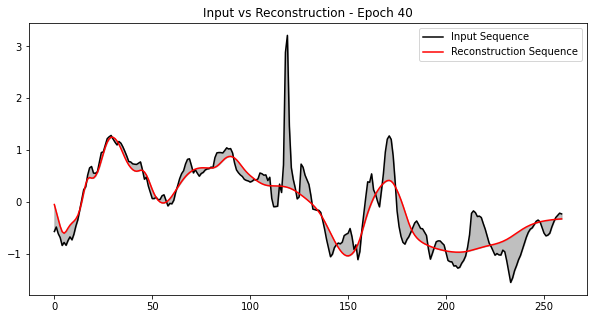

Epoch 41: train loss 69.1435879651238 val loss 70.4526153564453
Epoch 42: train loss 65.54987348668716 val loss 72.51065038793227
Epoch 43: train loss 66.75576997644761 val loss 68.12208709716796
Epoch 44: train loss 62.90740852355957 val loss 64.82811503690832
Epoch 45: train loss 64.17473745907054 val loss 68.29232476178338
Epoch 46: train loss 64.61590118408203 val loss 66.00611801147461
Epoch 47: train loss 62.188702123305376 val loss 66.89638487871956
Epoch 48: train loss 66.0764799005845 val loss 69.73409690856934
Epoch 49: train loss 69.94294168808881 val loss 68.95802212883444
Epoch 50: train loss 66.45679864322437 val loss 67.86021448023179
Epoch 51: train loss 64.89335286757526 val loss 68.98068152034983
Epoch 52: train loss 65.00754001841825 val loss 67.61810358832864
Epoch 53: train loss 66.56907649320715 val loss 75.48842941732967
Epoch 54: train loss 70.00032525904038 val loss 75.2151424632353
Epoch 55: train loss 70.85167388916015 val loss 76.51387277490953
Epoch 56: tra

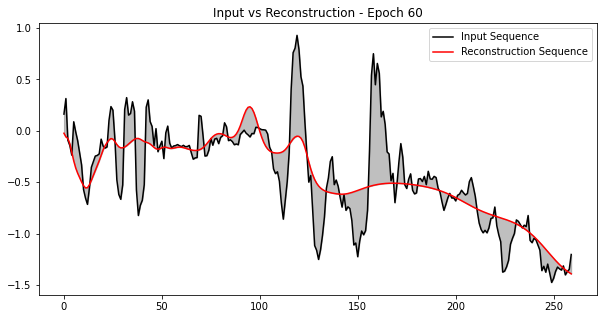

Epoch 61: train loss 68.06738357543945 val loss 68.31316469977884
Epoch 62: train loss 69.48917970096363 val loss 80.79410330828499
Epoch 63: train loss 78.44394028607537 val loss 84.8855110168457
Epoch 64: train loss 78.12140585955451 val loss 72.13778547399184
Epoch 65: train loss 70.4525312760297 val loss 66.85857353210449
Epoch 66: train loss 66.33876445994657 val loss 66.59222068786622
Epoch 67: train loss 66.67842102050781 val loss 67.92955854079302
Epoch 68: train loss 63.61287965213551 val loss 64.36521913865033
Epoch 69: train loss 63.675168632058536 val loss 75.08000245935777
Epoch 70: train loss 66.10936862721162 val loss 65.72081808202407
Epoch 71: train loss 66.58844366634594 val loss 66.53956516490263
Epoch 72: train loss 66.14606953789206 val loss 65.71459240632899
Epoch 73: train loss 65.8094820359174 val loss 65.11259931676528
Epoch 74: train loss 62.451421176686004 val loss 70.54598242815803
Epoch 75: train loss 63.29355271283318 val loss 70.92304016562069
Epoch 76: t

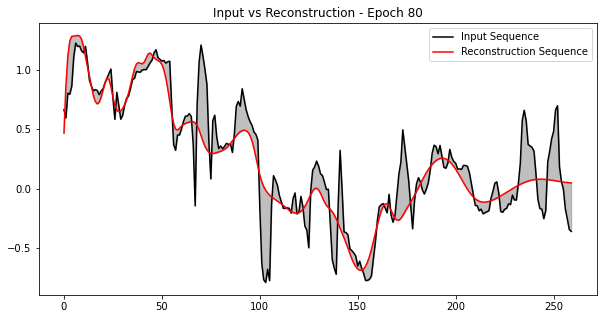

Epoch 81: train loss 65.0434788872214 val loss 70.5267292471493
Epoch 82: train loss 68.10608513775993 val loss 66.29150606043198
Epoch 83: train loss 64.68977921429803 val loss 67.00248161764706
Epoch 84: train loss 63.30601826836081 val loss 67.09381085564108
Saving best model
Epoch 85: train loss 63.93904037475586 val loss 60.6281032113468
Epoch 86: train loss 61.302522816377525 val loss 66.22890113381779
Epoch 87: train loss 65.06837322010713 val loss 67.72564596288345
Epoch 88: train loss 65.87957211662741 val loss 69.50563691083123
Epoch 89: train loss 65.64537225611069 val loss 69.85848426818848
Epoch 90: train loss 63.556822877771715 val loss 67.8224666146671
Epoch 91: train loss 64.78593105989344 val loss 69.97038610121783
Epoch 92: train loss 65.00839994093951 val loss 67.01504747727338
Epoch 93: train loss 65.14033550935633 val loss 71.54561884262982
Epoch 94: train loss 66.55405592076919 val loss 71.7012518265668
Epoch 95: train loss 68.58341757830452 val loss 65.5602044947

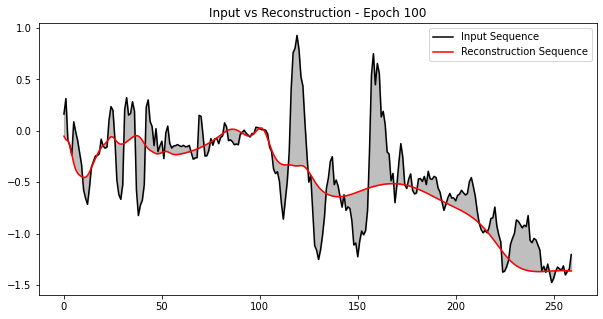

Epoch 101: train loss 67.835099141738 val loss 67.42529904982624
Epoch 102: train loss 65.97055953530705 val loss 75.13359731786392
Epoch 103: train loss 70.91961288452148 val loss 75.39238130906048
Epoch 104: train loss 65.94302507288316 val loss 66.94410660687615
Epoch 105: train loss 63.66647280524759 val loss 64.39738444160012
Epoch 106: train loss 62.96195860470043 val loss 65.77471802655388
Epoch 107: train loss 66.42769411872415 val loss 69.6839770821964
Epoch 108: train loss 63.5509983735926 val loss 63.23327192418716
Epoch 109: train loss 61.8843417448156 val loss 68.69475355709301
Epoch 110: train loss 62.639903236837945 val loss 63.51583918403177
Epoch 111: train loss 63.72203472361845 val loss 66.0332145690918
Epoch 112: train loss 65.63439945894129 val loss 69.42851575963637
Epoch 113: train loss 65.37642285964068 val loss 61.54345148871927
Epoch 114: train loss 61.224578857421875 val loss 72.97701716703527
Epoch 115: train loss 65.16237815408145 val loss 62.98446484734030

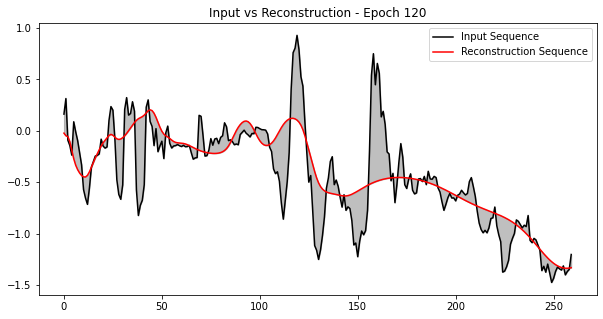

Epoch 121: train loss 62.65480447656968 val loss 62.99686622619629
Epoch 122: train loss 62.635176826925836 val loss 66.11790553822237
Epoch 123: train loss 65.18161481969497 val loss 63.34914229897892
Epoch 124: train loss 61.180921352610866 val loss 62.08354521358714
Epoch 125: train loss 60.69220347684973 val loss 65.10751782585592
Epoch 126: train loss 63.90596124985639 val loss 70.80978306041044
Epoch 127: train loss 65.4701301799101 val loss 64.1266622655532
Epoch 128: train loss 61.964440110150505 val loss 66.4861873626709
Epoch 129: train loss 66.25245410694795 val loss 66.11330339768354
Epoch 130: train loss 62.225406579410325 val loss 65.5692965114818
Epoch 131: train loss 63.891727492388554 val loss 64.3486193488626
Epoch 132: train loss 62.67318395726821 val loss 64.36139726077809
Epoch 133: train loss 60.94181702557732 val loss 67.07819238550523
Epoch 134: train loss 62.91161566341624 val loss 66.5020206227022
Epoch 135: train loss 62.68505446490119 val loss 64.35422776166

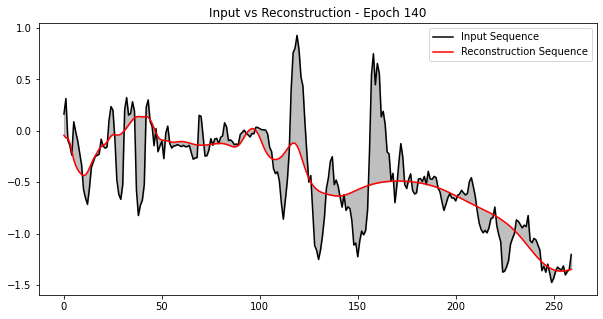

Epoch 141: train loss 63.177480697631836 val loss 61.826121027329386
Epoch 142: train loss 61.705961945477654 val loss 68.27673001008876
Epoch 143: train loss 63.543513421451344 val loss 66.58924578498392
Epoch 144: train loss 63.0415750615737 val loss 61.84454137016745
Epoch 145: train loss 63.42930991228889 val loss 70.2135508593391
Epoch 146: train loss 61.4064110475428 val loss 63.80894530801212
Epoch 147: train loss 62.3659704544965 val loss 70.1228598875158
Epoch 148: train loss 66.26916250341078 val loss 73.34559018752154
Epoch 149: train loss 70.16692635031308 val loss 75.25918675590964
Epoch 150: train loss 69.2145377888399 val loss 62.48337514540729
Epoch 151: train loss 70.6550967945772 val loss 77.05675396638757
Epoch 152: train loss 74.04273612078498 val loss 70.65988928850959
Epoch 153: train loss 66.73604370565975 val loss 64.75177536010742
Epoch 154: train loss 62.53823091843549 val loss 64.75213934954475
Epoch 155: train loss 64.09387572793399 val loss 64.7191533705767

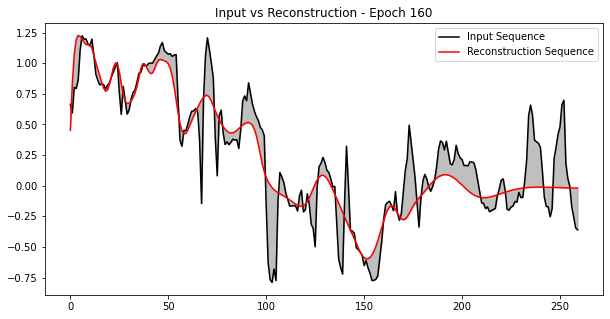

Epoch 161: train loss 61.68598980623133 val loss 61.072414667466106
Epoch 162: train loss 60.7880319258746 val loss 62.99858557757209
Epoch 163: train loss 59.9634594412411 val loss 66.64438146703384
Epoch 164: train loss 61.60929973826689 val loss 67.77834311092602
Epoch 165: train loss 65.7180253197165 val loss 69.67960788502413
Epoch 166: train loss 67.96600566190831 val loss 72.75597341200884
Epoch 167: train loss 72.41391009162454 val loss 68.06560947193819
Epoch 168: train loss 64.2084779178395 val loss 67.06635656917797
Epoch 169: train loss 68.59313069511862 val loss 67.4614824182847
Epoch 170: train loss 65.21738092759077 val loss 66.22531336616068
Epoch 171: train loss 65.72277378755457 val loss 67.11478962617763
Epoch 172: train loss 66.1824140885297 val loss 64.82420122483197
Epoch 173: train loss 64.59836849885828 val loss 61.67250141816981
Epoch 174: train loss 60.840423943014706 val loss 63.156726321052105
Epoch 175: train loss 63.16552303538603 val loss 62.8937405754538

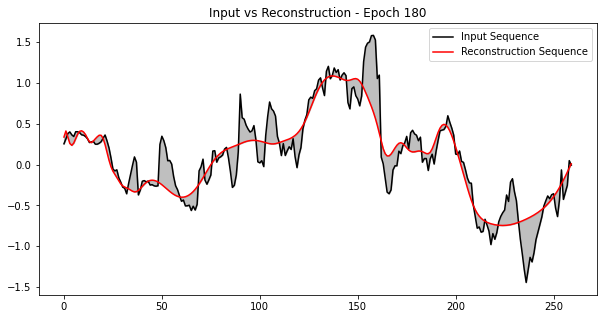

Epoch 181: train loss 60.95923776065602 val loss 64.95270697649788
Epoch 182: train loss 59.986810818840475 val loss 62.80500272863051
Epoch 183: train loss 60.333055945003736 val loss 61.163510199154125
Saving best model
Epoch 184: train loss 60.14696980644675 val loss 60.18410056619083
Epoch 185: train loss 60.48276452457203 val loss 61.48235637440401
Epoch 186: train loss 66.55630699606503 val loss 63.05604975083295
Epoch 187: train loss 63.2494774313534 val loss 72.45658892463236
Epoch 188: train loss 66.48917247547823 val loss 67.1743403042064
Epoch 189: train loss 63.36532967511345 val loss 65.5387508616728
Epoch 190: train loss 64.33568397970761 val loss 67.52828562119427
Epoch 191: train loss 65.52683702356676 val loss 73.23570143755744
Epoch 192: train loss 67.65088296778062 val loss 63.223027038574216
Epoch 193: train loss 60.02793951595531 val loss 64.05923295862534
Epoch 194: train loss 63.0130942400764 val loss 63.51574352488798
Epoch 195: train loss 62.22170230641085 val 

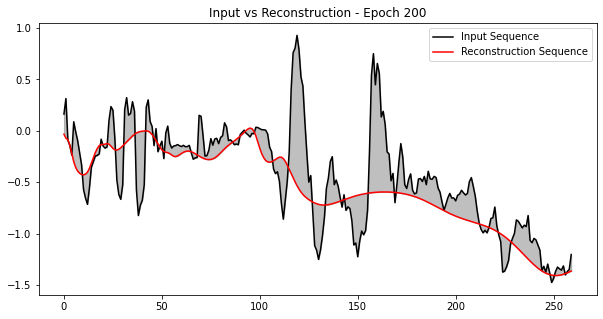

Epoch 201: train loss 86.50785475338206 val loss 82.00181061239803
Epoch 202: train loss 90.0403455397662 val loss 83.1456496070413
Epoch 203: train loss 84.07690413979923 val loss 76.2153772017535
Epoch 204: train loss 78.46626510620118 val loss 70.62555019154269
Epoch 205: train loss 69.91079442641315 val loss 70.37998838985668
Epoch 206: train loss 69.23005135480095 val loss 73.32849399342257
Epoch 207: train loss 68.64166670406566 val loss 72.30925050623277
Epoch 208: train loss 68.76125928093406 val loss 70.52019083359662
Epoch 209: train loss 70.83429830214557 val loss 70.48643468969009
Epoch 210: train loss 74.78734590866986 val loss 75.24627968283261
Epoch 211: train loss 73.01179015215705 val loss 72.76438170040355
Epoch 212: train loss 68.33061287823845 val loss 64.43175387663
Epoch 213: train loss 63.839439347211055 val loss 67.29845134510714
Epoch 214: train loss 66.34415689356187 val loss 66.81327256595387
Epoch 215: train loss 67.70691066068761 val loss 70.60803449294147


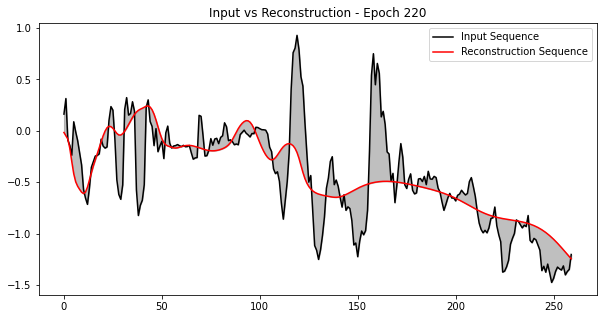

Epoch 221: train loss 67.24983186160817 val loss 65.44473374310662
Epoch 222: train loss 63.95452297435087 val loss 71.30959279677447
Epoch 223: train loss 66.04937766580021 val loss 71.78384789859547
Epoch 224: train loss 68.8180815304027 val loss 68.20111449746524
Epoch 225: train loss 65.72535413854263 val loss 76.41224223866182
Epoch 226: train loss 70.67753789565143 val loss 66.8785707361558
Epoch 227: train loss 66.60471824197208 val loss 76.34650659000172
Epoch 228: train loss 73.66973870221307 val loss 68.50473235635197
Epoch 229: train loss 68.97632430581486 val loss 72.37583019032198
Epoch 230: train loss 68.77877695420209 val loss 66.74996488234576
Epoch 231: train loss 75.41713963676901 val loss 96.33069590400247
Epoch 232: train loss 89.68144131828757 val loss 80.39164338953354
Epoch 233: train loss 79.62946938907399 val loss 79.16537114311667
Epoch 234: train loss 74.54604889364803 val loss 71.05121166004854
Epoch 235: train loss 73.47617331112133 val loss 75.651016302669

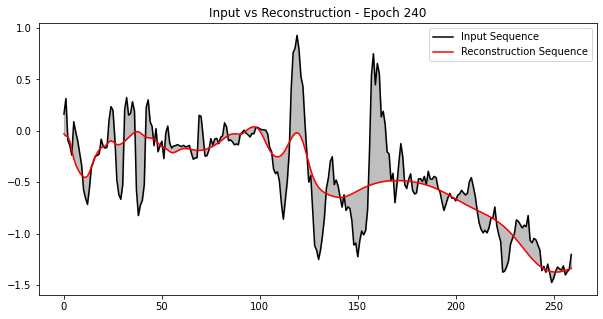

Epoch 241: train loss 62.90839545306037 val loss 64.81090747608857
Epoch 242: train loss 61.369217592127185 val loss 62.294642482084384
Epoch 243: train loss 63.141736131555895 val loss 63.26928758060231
Epoch 244: train loss 62.01334069195916 val loss 60.34163939532112
Epoch 245: train loss 61.54649106193991 val loss 69.81718321407543
Epoch 246: train loss 62.34818465288948 val loss 63.13389935212977
Epoch 247: train loss 62.87374844270594 val loss 64.9335501278148
Epoch 248: train loss 61.4603707706227 val loss 67.62354864232681
Epoch 249: train loss 68.14496233323041 val loss 70.59786206413717
Epoch 250: train loss 70.81550858441521 val loss 65.85349605784697
Epoch 251: train loss 74.20700856377097 val loss 72.08678153542911
Epoch 252: train loss 72.68794129315545 val loss 65.73786995831658
Epoch 253: train loss 65.29281326742733 val loss 64.65553896286909
Epoch 254: train loss 64.27642474454991 val loss 63.95416468452005
Epoch 255: train loss 61.77743810765884 val loss 65.445644109

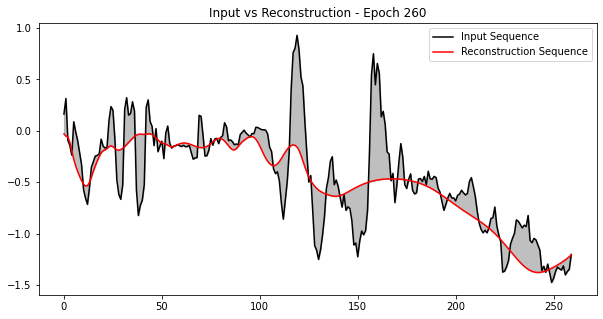

Saving best model
Epoch 261: train loss 62.877667842191805 val loss 59.078603497673484
Epoch 262: train loss 62.59929569468779 val loss 66.00082116968491
Epoch 263: train loss 63.325822875078984 val loss 67.93684595893411
Epoch 264: train loss 65.87466652814079 val loss 61.683237838745114
Epoch 265: train loss 61.63881779839011 val loss 63.47764535791734
Epoch 266: train loss 64.54612767836628 val loss 69.56298482558307
Epoch 267: train loss 65.68848022012149 val loss 66.10474404727711
Epoch 268: train loss 64.57657147575827 val loss 65.17284186868106
Epoch 269: train loss 62.9440606285544 val loss 67.25078712912166
Epoch 270: train loss 62.36789140140309 val loss 65.04425526787253
Epoch 271: train loss 60.5054791394402 val loss 59.28019404691808
Epoch 272: train loss 61.50479069878073 val loss 60.37217052684111
Epoch 273: train loss 60.461307166604435 val loss 60.604529212502875
Epoch 274: train loss 63.314458757288314 val loss 62.45845431159525
Epoch 275: train loss 62.36779587689568

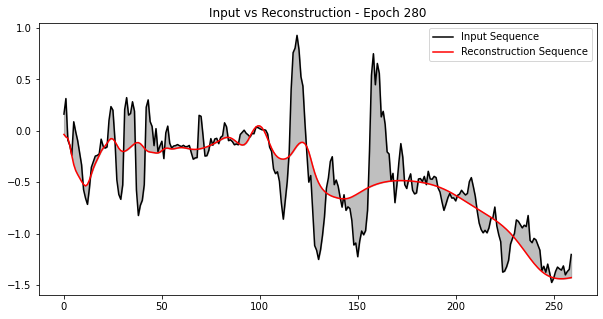

Epoch 281: train loss 63.54157728307388 val loss 67.69686622619629
Epoch 282: train loss 62.73538506451775 val loss 69.56469495436724
Epoch 283: train loss 63.80837081460392 val loss 63.76797855601591
Epoch 284: train loss 63.37930686053108 val loss 70.4721404580509
Epoch 285: train loss 68.7622729357551 val loss 60.865385773602654
Epoch 286: train loss 60.08638056586771 val loss 61.04777562758502
Saving best model
Epoch 287: train loss 60.29184662314022 val loss 58.76352325888241
Epoch 288: train loss 59.644405611823586 val loss 59.172549438476565
Epoch 289: train loss 59.975493509629196 val loss 66.86637164845186
Epoch 290: train loss 63.80109528934254 val loss 62.507297179278204
Epoch 291: train loss 63.85919609069824 val loss 62.08264175863827
Epoch 292: train loss 63.452261734008786 val loss 65.10242415035472
Epoch 293: train loss 62.860469234690946 val loss 72.06550095502068
Epoch 294: train loss 62.86521570542279 val loss 63.933336280373965
Epoch 295: train loss 63.5284135257496

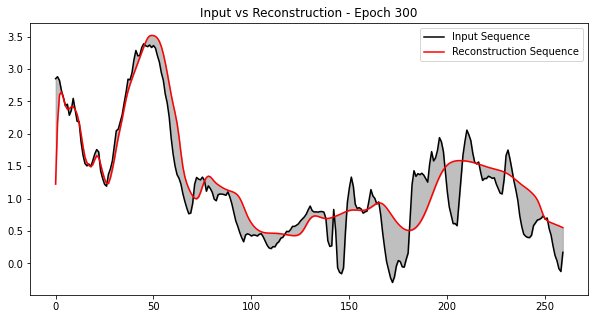

Epoch 301: train loss 63.12764665940229 val loss 59.53723676344928
Epoch 302: train loss 60.93198809904211 val loss 62.98776974397547
Epoch 303: train loss 61.34605865478515 val loss 60.53536493637983
Epoch 304: train loss 58.9068193323472 val loss 59.214727267097025
Epoch 305: train loss 60.65516878015855 val loss 66.67475388470818
Epoch 306: train loss 62.90138473510742 val loss 62.66151466369629
Epoch 307: train loss 62.05178386463839 val loss 65.05596086838666
Epoch 308: train loss 65.00023040771484 val loss 63.38689074796789
Epoch 309: train loss 61.171701386395625 val loss 61.32390650580911
Epoch 310: train loss 60.608898858463064 val loss 59.83410141888787
Epoch 311: train loss 58.72642754947438 val loss 59.65520356122185
Epoch 312: train loss 59.53868253371295 val loss 59.48048347024356
Epoch 313: train loss 60.1603713091682 val loss 67.00421746197868
Epoch 314: train loss 60.04879657520967 val loss 62.278028398401595
Epoch 315: train loss 61.32615625718061 val loss 60.18205745

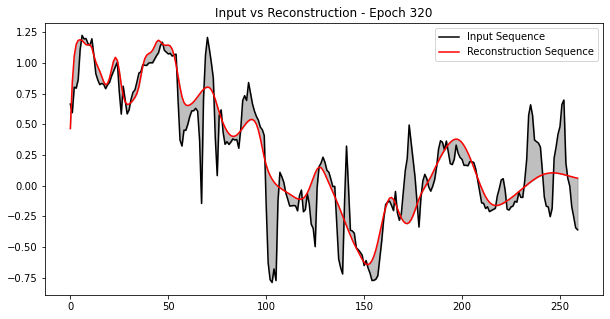

Epoch 321: train loss 62.440789076861215 val loss 63.85232267940746
Epoch 322: train loss 60.01064587761374 val loss 65.19504331700942
Epoch 323: train loss 61.84247896531049 val loss 60.627119535558364
Epoch 324: train loss 64.08004226684571 val loss 70.78485280205221
Epoch 325: train loss 64.55764187083525 val loss 69.6713950437658
Epoch 326: train loss 74.58295662823845 val loss 72.38269922593061
Epoch 327: train loss 74.8496971579159 val loss 71.30833212908577
Epoch 328: train loss 75.59325507668888 val loss 69.5192382588106
Epoch 329: train loss 67.87565864114201 val loss 63.45182371700511
Epoch 330: train loss 61.50582811692182 val loss 58.83969277774587
Epoch 331: train loss 57.01847787744859 val loss 61.321460028255686
Epoch 332: train loss 59.38352053025189 val loss 66.18130697362564
Epoch 333: train loss 61.05085368436926 val loss 62.631312875186694
Epoch 334: train loss 62.189998155481675 val loss 66.44886283874511
Epoch 335: train loss 61.09313096439137 val loss 65.06009142

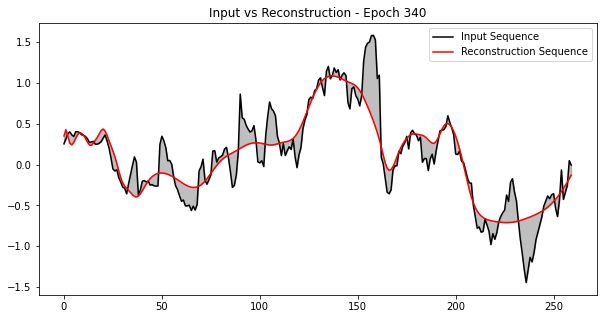

Epoch 341: train loss 61.49692501741297 val loss 65.84836300120634
Epoch 342: train loss 61.62234268188477 val loss 72.13823612437528
Epoch 343: train loss 65.63011308557847 val loss 63.615435050515565
Epoch 344: train loss 60.71424663768095 val loss 64.84445843416101
Epoch 345: train loss 60.57979072122013 val loss 70.41994157678941
Epoch 346: train loss 66.15173846974092 val loss 66.07444466983571
Epoch 347: train loss 66.36255125157973 val loss 65.14177984349868
Epoch 348: train loss 61.96820227679084 val loss 61.252629156673656
Epoch 349: train loss 61.59486335305606 val loss 73.75181274414062
Epoch 350: train loss 68.77275015887092 val loss 66.36594469407025
Epoch 351: train loss 62.114117992625516 val loss 62.54975294225356
Epoch 352: train loss 63.4944408865536 val loss 61.30115488837747
Epoch 353: train loss 59.33333253299489 val loss 63.58474816715016
Epoch 354: train loss 58.87913466060863 val loss 63.933628531063306
Epoch 355: train loss 59.03984884374282 val loss 65.6731059

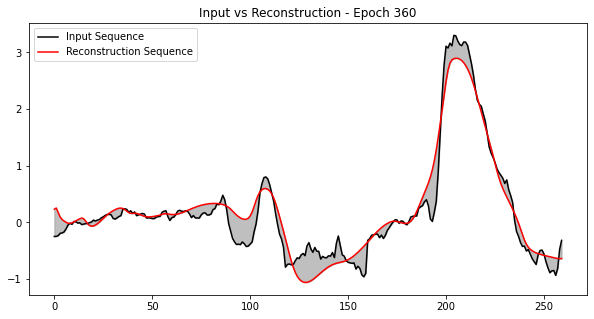

Epoch 361: train loss 61.413795403873216 val loss 62.981785022511204
Epoch 362: train loss 62.48876237308278 val loss 61.10757100722369
Saving best model
Epoch 363: train loss 58.003288067088405 val loss 58.33711669024299
Epoch 364: train loss 57.68926458919749 val loss 63.53094293930951
Epoch 365: train loss 62.125274613324336 val loss 62.96427681866814
Epoch 366: train loss 61.764518244126265 val loss 66.05764840069939
Epoch 367: train loss 64.15543733484604 val loss 61.58659654505112
Epoch 368: train loss 60.4539638968075 val loss 67.42699461544261
Epoch 369: train loss 62.88854118795956 val loss 63.71146101110122
Epoch 370: train loss 61.488293793622184 val loss 63.07059187047622
Epoch 371: train loss 64.145449627147 val loss 68.02332456252154
Epoch 372: train loss 64.49807032416848 val loss 60.93183324477252
Saving best model
Epoch 373: train loss 60.01990123075598 val loss 57.78041200076832
Epoch 374: train loss 59.42547293270336 val loss 59.69023682089413
Epoch 375: train loss 5

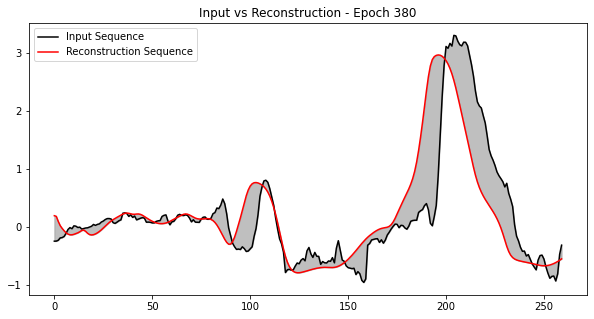

Epoch 381: train loss 69.95955087998334 val loss 63.726591783411365
Epoch 382: train loss 65.83326530456543 val loss 62.141341489904065
Epoch 383: train loss 61.18649182039149 val loss 63.69689409592572
Epoch 384: train loss 60.35257418015424 val loss 60.29617489085478
Epoch 385: train loss 59.407278285307044 val loss 58.979056459314684
Epoch 386: train loss 57.1261344909668 val loss 58.6333620632396
Epoch 387: train loss 56.97505778144388 val loss 60.75673383824966
Epoch 388: train loss 64.04021456101361 val loss 76.59356056662166
Epoch 389: train loss 70.71170082092286 val loss 80.80697730569278
Epoch 390: train loss 77.34603444267722 val loss 62.878702545166014
Epoch 391: train loss 61.59001336939195 val loss 60.30018658357508
Epoch 392: train loss 58.95555761000689 val loss 61.237440131692324
Epoch 393: train loss 60.96545520109289 val loss 63.06326244578642
Epoch 394: train loss 60.09136922499713 val loss 64.22873582278982
Epoch 395: train loss 61.20358067680807 val loss 69.454025

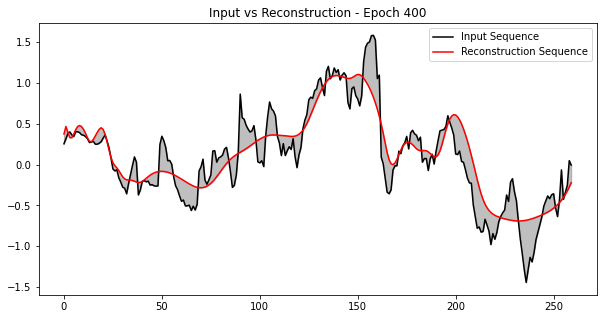

Epoch 401: train loss 69.40819753759048 val loss 70.13246931188247
Epoch 402: train loss 63.86269412321203 val loss 65.29013990514419
Epoch 403: train loss 60.201171785242416 val loss 59.3297446531408
Epoch 404: train loss 57.47864922916188 val loss 60.113597264009364
Epoch 405: train loss 59.03045414195341 val loss 63.16510353088379
Epoch 406: train loss 61.949873733520505 val loss 63.07812724393957
Epoch 407: train loss 61.459474406522865 val loss 73.01197660109577
Epoch 408: train loss 67.79355031181784 val loss 62.53973895802218
Epoch 409: train loss 62.76142450220445 val loss 68.0530185250675
Epoch 410: train loss 63.64121095993939 val loss 63.42448927935432
Epoch 411: train loss 64.21005141314338 val loss 61.77355391558479
Epoch 412: train loss 61.07860228594612 val loss 62.45174080343808
Epoch 413: train loss 59.87466096317067 val loss 59.25190335442038
Epoch 414: train loss 60.032739751479205 val loss 65.18958147834329
Epoch 415: train loss 60.04023067249971 val loss 58.6075167

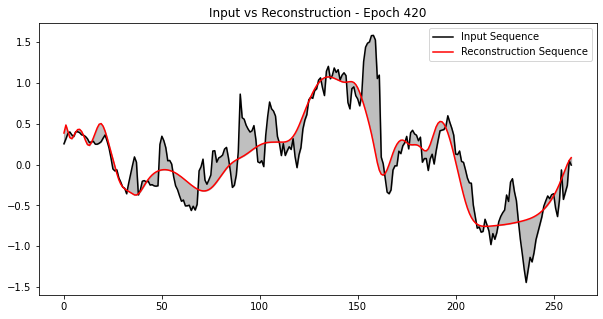

Epoch 421: train loss 62.10562306572409 val loss 63.55454485276166
Epoch 422: train loss 59.64252680610208 val loss 62.988377470128675
Epoch 423: train loss 60.26409759521484 val loss 60.01822155223173
Epoch 424: train loss 60.04539864484001 val loss 59.361398292990295
Epoch 425: train loss 59.12259272407083 val loss 61.69468047198127
Epoch 426: train loss 60.80377127703498 val loss 60.4901377734016
Epoch 427: train loss 58.17799310123219 val loss 66.26551897385541
Epoch 428: train loss 58.8872787026798 val loss 64.96850143881404
Epoch 429: train loss 62.423586564905506 val loss 61.5104102415197
Epoch 430: train loss 61.582543967751896 val loss 73.7490083806655
Epoch 431: train loss 70.62067779092227 val loss 67.11851135702695
Epoch 432: train loss 62.43311397328096 val loss 61.025582818424
Epoch 433: train loss 61.324073140761435 val loss 62.231326630536245
Epoch 434: train loss 59.010318800982304 val loss 64.77510189729578
Epoch 435: train loss 61.55596609676586 val loss 66.184539525

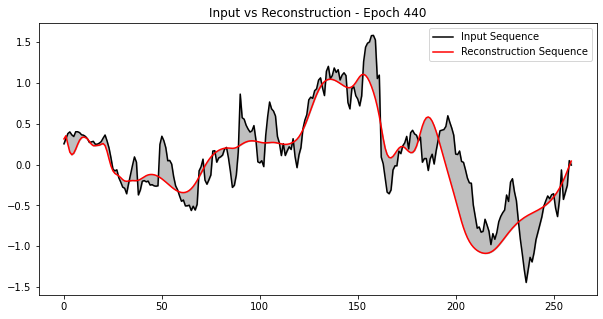

Epoch 441: train loss 63.93647640452665 val loss 68.12514888539033
Epoch 442: train loss 67.52365857292624 val loss 65.17824397367589
Epoch 443: train loss 61.990411893059225 val loss 65.74431536057416
Epoch 444: train loss 64.91044861288631 val loss 63.01300107170554
Epoch 445: train loss 58.565315269021426 val loss 61.15785894954906
Epoch 446: train loss 61.80210921343635 val loss 63.849518293492935
Epoch 447: train loss 61.04224685220157 val loss 62.95442976110122
Epoch 448: train loss 59.03840500326718 val loss 60.62133856380687
Epoch 449: train loss 61.33167731341194 val loss 59.38997194626752
Epoch 450: train loss 57.92573794196634 val loss 64.2294901006362
Epoch 451: train loss 57.47876297445858 val loss 62.24957077923943
Epoch 452: train loss 58.10965677149156 val loss 58.7868631475112
Epoch 453: train loss 60.66832356172449 val loss 64.63755722045899
Epoch 454: train loss 60.78050063638126 val loss 64.99119195377125
Epoch 455: train loss 59.622672428804286 val loss 59.47721393

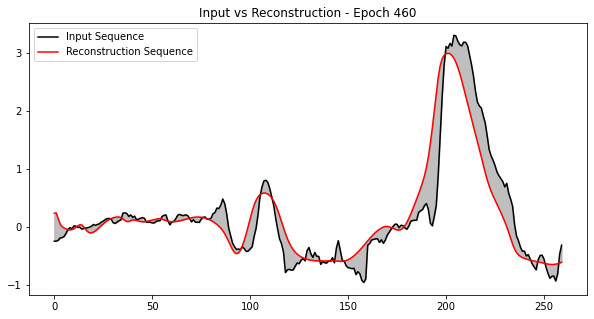

Epoch 461: train loss 63.627891136618224 val loss 65.4681692460004
Epoch 462: train loss 60.080762414371264 val loss 68.27503291859347
Epoch 463: train loss 65.46279981276568 val loss 60.526489706600415
Epoch 464: train loss 59.6413859647863 val loss 67.04988564883962
Epoch 465: train loss 63.2538392459645 val loss 68.2515697703642
Epoch 466: train loss 60.190954814237706 val loss 65.45957201789408
Epoch 467: train loss 63.50776542214786 val loss 65.07837941786822
Epoch 468: train loss 60.556591550041645 val loss 64.60608260210823
Epoch 469: train loss 61.58221056321088 val loss 62.88847873912138
Epoch 470: train loss 61.30171811720904 val loss 64.13342608283548
Epoch 471: train loss 60.86098022460938 val loss 61.16551848018871
Epoch 472: train loss 61.64253937216366 val loss 63.609188034955196
Epoch 473: train loss 60.97481711892521 val loss 73.63447858025046
Epoch 474: train loss 63.3144723331227 val loss 64.15943471123191
Epoch 475: train loss 61.69005746280446 val loss 66.998885435

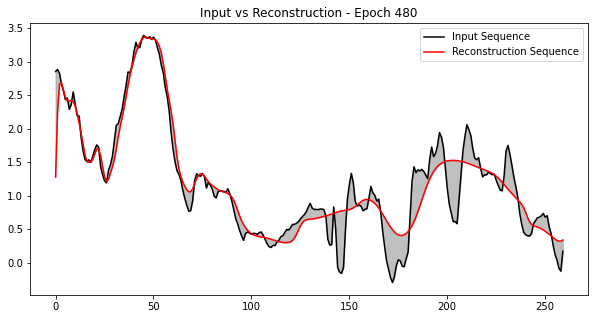

Epoch 481: train loss 58.85060588612276 val loss 60.77552479014677
Epoch 482: train loss 58.07523251701804 val loss 58.12207899654613
Epoch 483: train loss 57.905638728422275 val loss 57.95902131024529
Epoch 484: train loss 58.49797031178194 val loss 72.08712155959185
Epoch 485: train loss 62.21693707634421 val loss 61.89083545909208
Epoch 486: train loss 58.82347759920008 val loss 73.41436646405388
Epoch 487: train loss 66.35699339473949 val loss 62.429627384858975
Epoch 488: train loss 62.719131424847774 val loss 63.61786813174977
Epoch 489: train loss 62.01378176072065 val loss 65.99546118343578
Epoch 490: train loss 58.95541096855612 val loss 67.33616333007812
Epoch 491: train loss 60.72341559914982 val loss 60.80389025071088
Epoch 492: train loss 62.763540492338294 val loss 62.04418920629165
Epoch 493: train loss 59.03568700902602 val loss 62.55046550526338
Epoch 494: train loss 57.67960337470559 val loss 64.12213567845961
Epoch 495: train loss 63.0661537843592 val loss 66.7567151

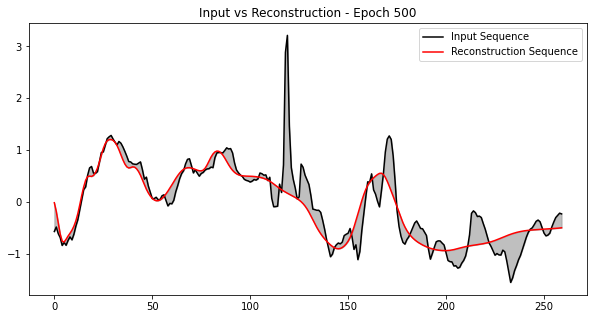

Epoch 501: train loss 63.89541132309858 val loss 58.08756529864143
Epoch 502: train loss 59.746760559082034 val loss 66.57965857561896
Epoch 503: train loss 65.86533052781049 val loss 63.4983700022978
Epoch 504: train loss 60.699726912554574 val loss 63.61486158931957
Epoch 505: train loss 62.20456136815688 val loss 61.475893693811756
Epoch 506: train loss 57.552304144466625 val loss 58.398603327134076
Epoch 507: train loss 58.784836286657 val loss 60.332539233039405
Epoch 508: train loss 59.061565533806295 val loss 61.22320496054257
Epoch 509: train loss 58.66321361766142 val loss 60.75567182653091
Epoch 510: train loss 57.43667239020853 val loss 62.19917142531451
Epoch 511: train loss 61.380021645041076 val loss 71.04820442199707
Epoch 512: train loss 63.24640630834243 val loss 64.49557266235351
Epoch 513: train loss 64.46627859227797 val loss 64.19967889224782
Epoch 514: train loss 63.03536872863769 val loss 64.08985750534956
Epoch 515: train loss 60.138949427885166 val loss 67.7286

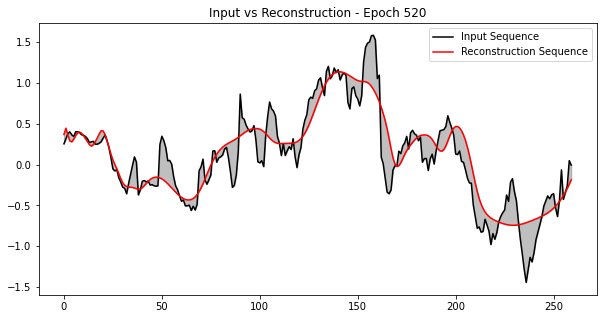

Epoch 521: train loss 57.988461662741265 val loss 61.92504171483657
Epoch 522: train loss 60.070819607902976 val loss 61.49327655119055
Epoch 523: train loss 60.026825242884016 val loss 59.33028212154613
Epoch 524: train loss 61.024786219877356 val loss 63.93372237261604
Epoch 525: train loss 61.91783934200511 val loss 64.9526736315559
Epoch 526: train loss 59.67375315497903 val loss 61.660263689826515
Epoch 527: train loss 59.970015514598174 val loss 62.6412067637724
Epoch 528: train loss 59.03112775017233 val loss 59.868948027666875
Epoch 529: train loss 57.7318531036377 val loss 60.088284750545725
Epoch 530: train loss 60.34319653230555 val loss 60.22267987868365
Epoch 531: train loss 58.70584220886231 val loss 62.76249802533318
Epoch 532: train loss 65.91668719123392 val loss 61.115648471607884
Epoch 533: train loss 61.46916059606215 val loss 58.94675299700569
Epoch 534: train loss 57.16256419911104 val loss 60.30793701620663
Epoch 535: train loss 59.461055755615234 val loss 59.858

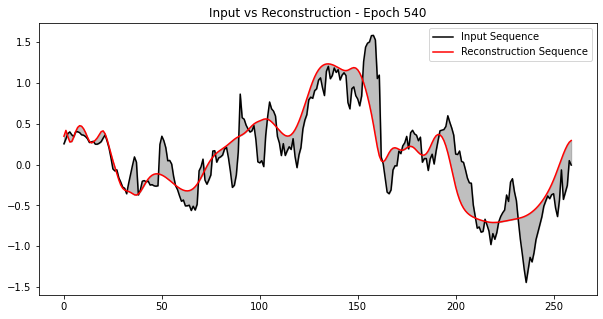

Epoch 541: train loss 59.49313516055837 val loss 60.83822124705595
Epoch 542: train loss 60.03711550095502 val loss 65.38628369499655
Epoch 543: train loss 61.6609079248765 val loss 65.68198179357192
Epoch 544: train loss 63.61488654192756 val loss 67.17511347602395
Epoch 545: train loss 63.84249119478113 val loss 64.61968796673943
Epoch 546: train loss 61.80554010727826 val loss 63.09643150778378
Epoch 547: train loss 60.45721882090849 val loss 67.50889434814454
Epoch 548: train loss 65.83565557143268 val loss 65.77231611364029
Epoch 549: train loss 62.477812307021196 val loss 64.82976051779355
Epoch 550: train loss 63.22058192982393 val loss 61.35518013449276
Epoch 551: train loss 58.65210652070887 val loss 63.185886472814225
Epoch 552: train loss 63.03797203512753 val loss 63.01890043370864
Epoch 553: train loss 59.62584623448989 val loss 69.12798769333783
Epoch 554: train loss 67.42824944888844 val loss 70.71754572251264
Epoch 555: train loss 63.03201836978688 val loss 68.384348813

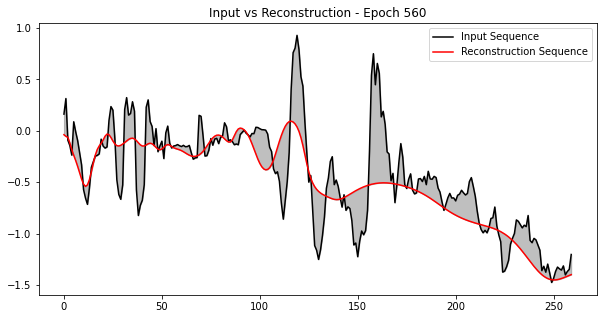

Epoch 561: train loss 59.24624472225413 val loss 60.551497380873734
Epoch 562: train loss 60.14145646936753 val loss 59.13368182462804
Epoch 563: train loss 59.39540335711311 val loss 60.194263054342834
Epoch 564: train loss 59.587557467292335 val loss 58.899135095932905
Epoch 565: train loss 57.3571091595818 val loss 62.19384204640108
Epoch 566: train loss 58.43846437790815 val loss 61.593367498061234
Epoch 567: train loss 59.76582482281853 val loss 63.98107537662282
Epoch 568: train loss 61.97049699671128 val loss 62.4745641820571
Epoch 569: train loss 63.19859753776999 val loss 65.73924230687759
Epoch 570: train loss 60.24634316388298 val loss 66.27025664834416
Epoch 571: train loss 60.23439800038057 val loss 67.8352388718549
Epoch 572: train loss 65.64019351286046 val loss 71.97893634122961
Epoch 573: train loss 63.76010282179889 val loss 66.78577133627499
Epoch 574: train loss 62.04130325317383 val loss 59.86685326520134
Epoch 575: train loss 59.604911961274986 val loss 60.7577271

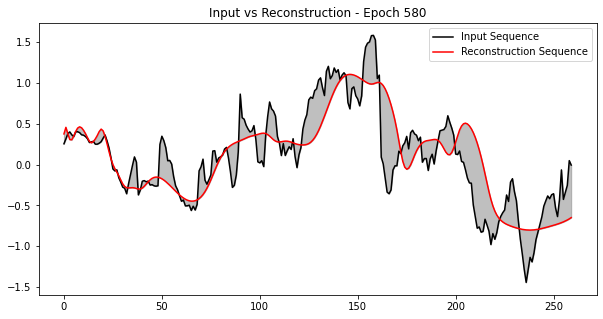

Epoch 581: train loss 59.43058395385742 val loss 63.64389228820801
Epoch 582: train loss 62.34217675152947 val loss 65.97198371887207
Epoch 583: train loss 61.278614694931925 val loss 69.91808215870577
Epoch 584: train loss 63.21554774116068 val loss 59.31021373973173
Epoch 585: train loss 58.144225580552046 val loss 62.89664982066435
Epoch 586: train loss 60.947345599006205 val loss 63.28265546910903
Epoch 587: train loss 59.0396338743322 val loss 72.38327704036936
Epoch 588: train loss 67.33349465762868 val loss 63.553294529634364
Epoch 589: train loss 62.123279055427105 val loss 66.72635080674115
Epoch 590: train loss 62.56467987509335 val loss 64.3377082824707
Epoch 591: train loss 61.31078493454877 val loss 60.52074874429142
Epoch 592: train loss 60.085154701681695 val loss 60.23306990230785
Epoch 593: train loss 60.835981009988224 val loss 70.52526402192957
Epoch 594: train loss 61.401481022554286 val loss 65.05237193388098
Epoch 595: train loss 61.73216326096479 val loss 69.6714

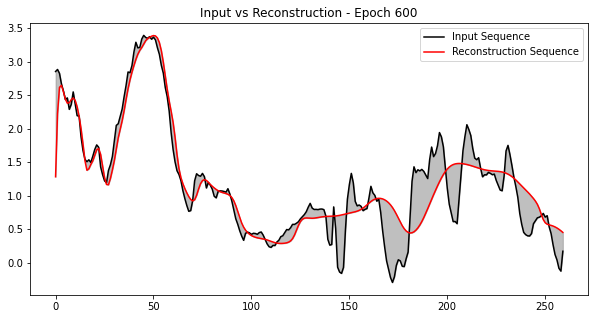

Epoch 601: train loss 58.80630051107968 val loss 59.217297542796416
Epoch 602: train loss 58.009038431504194 val loss 57.51180305480957
Epoch 603: train loss 56.61855785145479 val loss 59.69557957368738
Epoch 604: train loss 60.54646384295295 val loss 59.96881576986874
Epoch 605: train loss 60.15943179411047 val loss 59.12784610075109
Epoch 606: train loss 57.12484999263988 val loss 65.18202106251437
Epoch 607: train loss 62.15998198565315 val loss 60.10715513790355
Epoch 608: train loss 59.991764180800494 val loss 60.17059965694652
Epoch 609: train loss 61.354104389863856 val loss 62.05311187295353
Epoch 610: train loss 61.886477952844956 val loss 65.73176659976735
Epoch 611: train loss 61.28983174492331 val loss 60.22750921810375
Epoch 612: train loss 60.91812432233025 val loss 62.0572587630328
Epoch 613: train loss 58.83244352901683 val loss 59.1628786648021
Epoch 614: train loss 58.54206740435432 val loss 66.58805598090677
Epoch 615: train loss 57.317978107228 val loss 59.309110394

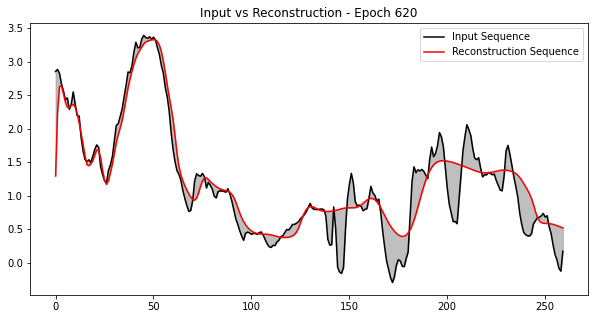

Epoch 621: train loss 56.437083592134364 val loss 58.52447314542883
Epoch 622: train loss 56.24986157136805 val loss 55.935039767097024
Epoch 623: train loss 57.73549317752614 val loss 56.13196617575253
Epoch 624: train loss 54.793548045438875 val loss 58.790122469733745
Epoch 625: train loss 58.110171980016375 val loss 60.049555834601904
Epoch 626: train loss 60.957134022432214 val loss 61.80646326401654
Epoch 627: train loss 58.526161193847656 val loss 62.406236154892866
Epoch 628: train loss 59.191830915563244 val loss 60.81130314995261
Epoch 629: train loss 58.94288626278148 val loss 64.58730587678797
Epoch 630: train loss 57.80993544634651 val loss 61.99684389899759
Epoch 631: train loss 59.885125418270334 val loss 64.2587542589973
Epoch 632: train loss 60.57083493401022 val loss 60.524830178653495
Epoch 633: train loss 58.69607182671042 val loss 60.375935655481676
Epoch 634: train loss 59.514788032980526 val loss 65.13195782829733
Epoch 635: train loss 61.018496345071235 val loss

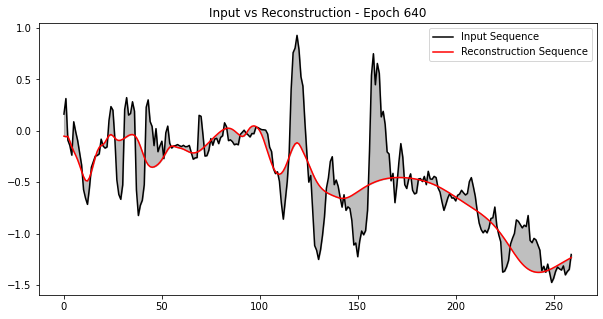

Epoch 641: train loss 65.06506287069881 val loss 64.08701041726505
Epoch 642: train loss 59.70657875958611 val loss 61.124845818912284
Epoch 643: train loss 59.132954339420095 val loss 60.733734422571516
Epoch 644: train loss 58.3119255065918 val loss 58.21448285719928
Epoch 645: train loss 57.55605453042423 val loss 59.12504631491269
Epoch 646: train loss 58.020776973051184 val loss 63.41907400243423
Epoch 647: train loss 61.05773501676671 val loss 61.15416228350471
Epoch 648: train loss 58.818016119564284 val loss 60.35747267779182
Epoch 649: train loss 58.99943230572869 val loss 59.28560304080739
Epoch 650: train loss 57.41674362631405 val loss 65.43246076247272
Epoch 651: train loss 62.250684536204616 val loss 62.42487445158117
Epoch 652: train loss 58.751161238726446 val loss 61.75013654372271
Epoch 653: train loss 61.85402163337259 val loss 64.03347277921789
Epoch 654: train loss 60.98219014336081 val loss 63.99037897446576
Epoch 655: train loss 62.74685653237736 val loss 62.7765

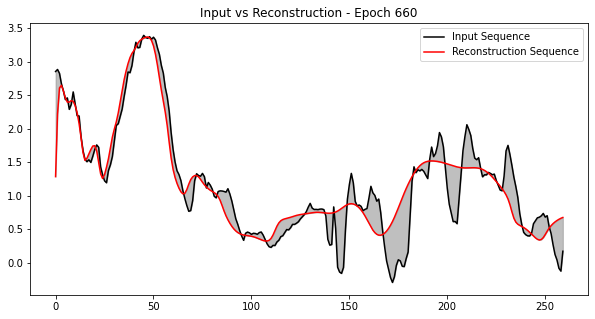

Epoch 661: train loss 65.43676748836742 val loss 60.18669765696806
Epoch 662: train loss 57.63819624956916 val loss 60.31390919404871
Epoch 663: train loss 61.059277523265166 val loss 58.9284621294807
Epoch 664: train loss 58.69909259571749 val loss 57.86317749023438
Epoch 665: train loss 57.6992182114545 val loss 62.392047096701226
Epoch 666: train loss 59.038535017125746 val loss 56.73277188469382
Epoch 667: train loss 54.80968084896312 val loss 64.14105556712431
Epoch 668: train loss 60.08412316266228 val loss 59.637399090037626
Epoch 669: train loss 57.65588102901683 val loss 60.559621855791875
Epoch 670: train loss 60.089178062887754 val loss 64.50726973589728
Epoch 671: train loss 59.973598457785215 val loss 57.36397689370548
Epoch 672: train loss 57.10894651973949 val loss 64.77332086002126
Epoch 673: train loss 59.72674800648409 val loss 61.77787908666274
Epoch 674: train loss 60.83699004229377 val loss 65.06599047043744
Epoch 675: train loss 60.211571525124945 val loss 57.9287

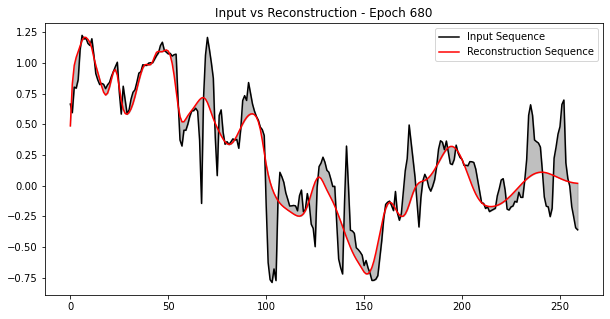

Epoch 681: train loss 56.16867559096392 val loss 67.50099956288057
Epoch 682: train loss 62.4547836303711 val loss 63.80923015370089
Epoch 683: train loss 59.43358488643871 val loss 71.73285374360925
Epoch 684: train loss 64.0167490790872 val loss 59.04124652638155
Epoch 685: train loss 57.40188876881319 val loss 64.57787648369285
Epoch 686: train loss 58.723276385139016 val loss 57.987769070793604
Epoch 687: train loss 56.99021343904383 val loss 59.922687216366036
Epoch 688: train loss 58.14859396990608 val loss 55.84956451864804
Epoch 689: train loss 54.7057071685791 val loss 58.89623574649586
Epoch 690: train loss 56.62337590385886 val loss 57.515913660386026
Epoch 691: train loss 56.32412789288689 val loss 60.035128223194796
Epoch 692: train loss 61.183677628461055 val loss 56.58526600108427
Epoch 693: train loss 58.17292960671818 val loss 56.83677042792825
Epoch 694: train loss 56.03160570930032 val loss 58.59690031163833
Epoch 695: train loss 56.764324277990006 val loss 58.200938

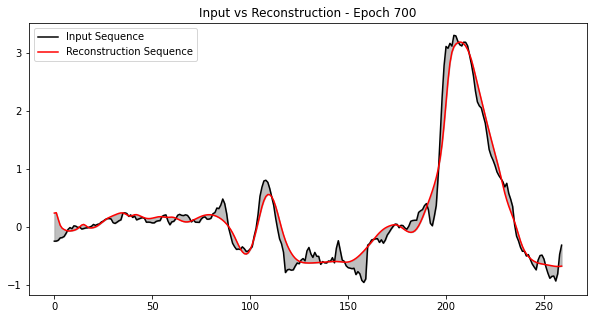

Epoch 701: train loss 56.15471395604751 val loss 66.22607639537138
Epoch 702: train loss 60.53273988611558 val loss 61.09719146279728
Epoch 703: train loss 58.962775264066806 val loss 60.978278777178595
Epoch 704: train loss 61.014926573809454 val loss 56.698678095200485
Epoch 705: train loss 55.09633053050322 val loss 59.735813275505514
Epoch 706: train loss 54.78668785095215 val loss 60.259268569946286
Epoch 707: train loss 57.12378490672392 val loss 58.09432478512035
Epoch 708: train loss 55.08630721148322 val loss 56.33374133390539
Epoch 709: train loss 56.34001283084645 val loss 58.03394829245175
Epoch 710: train loss 58.88408667620491 val loss 61.66838818718405
Epoch 711: train loss 62.81671034869026 val loss 64.84811973571777
Epoch 712: train loss 62.93206775889677 val loss 60.80742717069738
Epoch 713: train loss 60.01589442982393 val loss 60.41129206489114
Epoch 714: train loss 57.65746513815487 val loss 59.841106616749485
Epoch 715: train loss 57.30666822545669 val loss 59.528

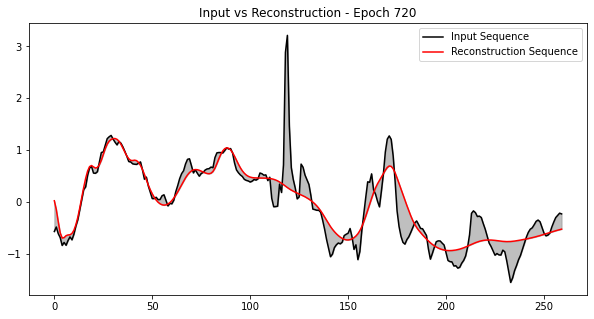

Saving best model
Epoch 721: train loss 55.03762785967658 val loss 54.45117591409122
Epoch 722: train loss 54.448109929701864 val loss 55.32265061771169
Epoch 723: train loss 56.72734626321232 val loss 61.430982679479264
Epoch 724: train loss 56.67348704618566 val loss 55.60154883440803
Epoch 725: train loss 57.24802028431612 val loss 61.01584192163804
Epoch 726: train loss 58.31374208786908 val loss 61.69167859694537
Epoch 727: train loss 56.81192209580365 val loss 63.594051293765794
Epoch 728: train loss 58.107078036139995 val loss 67.47389901105096
Epoch 729: train loss 62.21193266475902 val loss 62.6228458628935
Epoch 730: train loss 60.44703665340648 val loss 61.474628426046934
Epoch 731: train loss 55.771999628403606 val loss 54.93627705293543
Epoch 732: train loss 56.07320769814884 val loss 63.72189912235036
Epoch 733: train loss 59.12822202794692 val loss 59.54301461612477
Epoch 734: train loss 59.22428476670209 val loss 58.60472340303309
Epoch 735: train loss 56.86853538961971

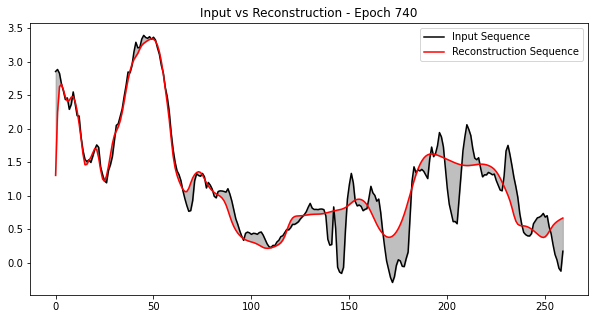

Epoch 741: train loss 55.613573164098405 val loss 59.99580746818991
Epoch 742: train loss 57.15385304619284 val loss 60.66077120163862
Epoch 743: train loss 57.93774645188275 val loss 66.8998348236084
Epoch 744: train loss 59.95417437833898 val loss 64.10222264458152
Epoch 745: train loss 64.67445229923024 val loss 59.553392859066236
Epoch 746: train loss 56.85116413340849 val loss 59.40621739555807
Epoch 747: train loss 62.04992541144876 val loss 66.35475374109605
Epoch 748: train loss 59.64042149712058 val loss 62.957190210678995
Epoch 749: train loss 60.55770252452177 val loss 66.04384105906767
Epoch 750: train loss 62.99705085754395 val loss 62.021002623614145
Epoch 751: train loss 56.88459694806267 val loss 62.218981754078584
Epoch 752: train loss 58.10297458873075 val loss 57.96854467952953
Epoch 753: train loss 55.587521362304685 val loss 57.87490743749282
Epoch 754: train loss 58.48937420564539 val loss 58.82377992517808
Epoch 755: train loss 63.11659765804515 val loss 67.58225

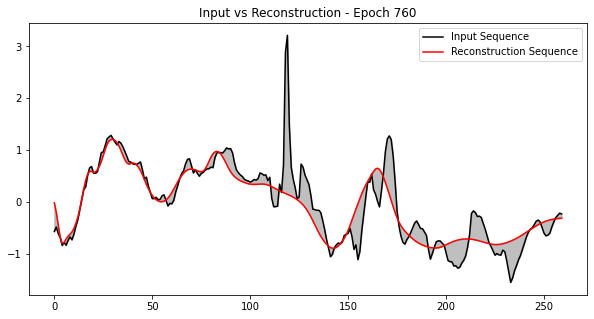

Epoch 761: train loss 55.646294268439796 val loss 56.097582065357884
Epoch 762: train loss 55.04830652124741 val loss 59.61489163567038
Epoch 763: train loss 57.336648492252124 val loss 63.66258890488569
Epoch 764: train loss 61.04429788028493 val loss 61.40293211095474
Epoch 765: train loss 58.642176078347596 val loss 61.42384551553165
Epoch 766: train loss 60.891599340999825 val loss 61.169330753999596
Epoch 767: train loss 59.829328065759995 val loss 57.905204683191634
Epoch 768: train loss 56.10393019283519 val loss 60.296337755988624
Epoch 769: train loss 55.96080681295956 val loss 56.00883118124569
Epoch 770: train loss 56.895499106014476 val loss 60.15363610211541
Epoch 771: train loss 58.63698441000546 val loss 59.86269641203039
Epoch 772: train loss 59.71390481836656 val loss 59.173097453397865
Epoch 773: train loss 56.7760394376867 val loss 58.6434508155374
Epoch 774: train loss 58.78336300569422 val loss 60.50454408982221
Epoch 775: train loss 58.53758190379423 val loss 58.1

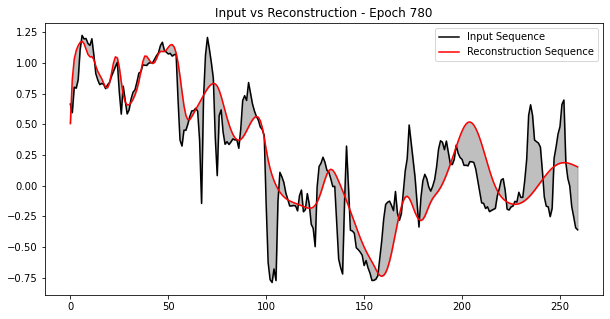

Epoch 781: train loss 57.94587759130141 val loss 59.24220715691062
Epoch 782: train loss 56.906332217945774 val loss 65.58022189420812
Epoch 783: train loss 58.21240802091711 val loss 57.343949800379136
Epoch 784: train loss 53.66331194709329 val loss 61.151125560087316
Epoch 785: train loss 55.05947961246266 val loss 55.678337904986215
Epoch 786: train loss 56.097256873635686 val loss 58.603590348187616
Epoch 787: train loss 57.79772109985352 val loss 56.32104011984433
Epoch 788: train loss 56.75392426883473 val loss 56.86681408601649
Epoch 789: train loss 56.372894466624544 val loss 56.95969731947955
Epoch 790: train loss 59.342184156530045 val loss 56.87031936645508
Epoch 791: train loss 56.551327694163604 val loss 56.6604736552519
Epoch 792: train loss 54.56478262508617 val loss 56.50101527045755
Epoch 793: train loss 56.21732368469238 val loss 58.09962970509249
Epoch 794: train loss 55.87943624608657 val loss 55.70662545596852
Epoch 795: train loss 56.142861826279585 val loss 59.6

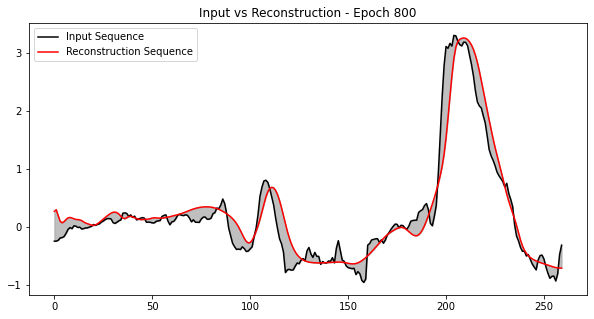

Epoch 801: train loss 58.49419452442842 val loss 58.80722106484806
Epoch 802: train loss 58.72069751515108 val loss 59.034603904275336
Epoch 803: train loss 58.202844328038836 val loss 58.384265675264245
Epoch 804: train loss 57.34714337517234 val loss 58.72897134668687
Epoch 805: train loss 57.339025385239545 val loss 59.80054936128504
Epoch 806: train loss 57.304975442325365 val loss 62.18102495530072
Epoch 807: train loss 59.45563991771025 val loss 60.72303013521082
Epoch 808: train loss 57.38063949136173 val loss 60.119603931202604
Epoch 809: train loss 58.24376981398638 val loss 62.130536920884076
Epoch 810: train loss 57.529999138327206 val loss 61.453439308615295
Epoch 811: train loss 59.030079179651594 val loss 66.59641932319192
Epoch 812: train loss 58.84858993081485 val loss 65.51263165193446
Epoch 813: train loss 61.16736106872558 val loss 59.14340254839729
Epoch 814: train loss 55.162730048684516 val loss 55.98447537141688
Epoch 815: train loss 54.91219650717343 val loss 62

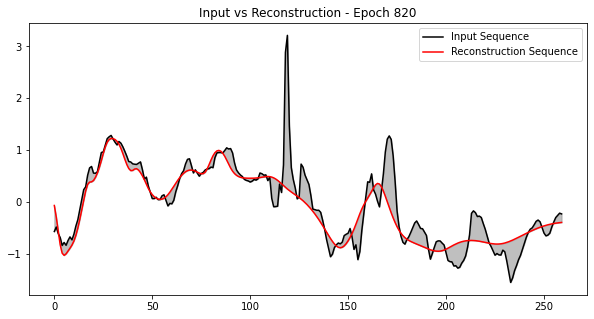

Epoch 821: train loss 56.07083188225241 val loss 61.80455757589901
Epoch 822: train loss 58.447840612074906 val loss 56.83546613805434
Epoch 823: train loss 55.43537009744083 val loss 59.675231013578525
Epoch 824: train loss 57.06406339757583 val loss 60.38154209361357
Epoch 825: train loss 57.99171351264505 val loss 61.3647133546717
Epoch 826: train loss 56.73763672323788 val loss 59.431840358060946
Epoch 827: train loss 59.268053032370176 val loss 60.548257266773895
Epoch 828: train loss 54.073764890782975 val loss 55.78315658569336
Epoch 829: train loss 55.332653920790726 val loss 56.89585831586052
Epoch 830: train loss 55.31397294437184 val loss 57.757464330336624
Epoch 831: train loss 53.68645573784323 val loss 63.36115354650161
Epoch 832: train loss 56.61045498567469 val loss 63.22608757019043
Epoch 833: train loss 61.15787508347455 val loss 64.10225255629595
Epoch 834: train loss 60.1116299348719 val loss 61.694871453677905
Epoch 835: train loss 57.14227898541619 val loss 58.405

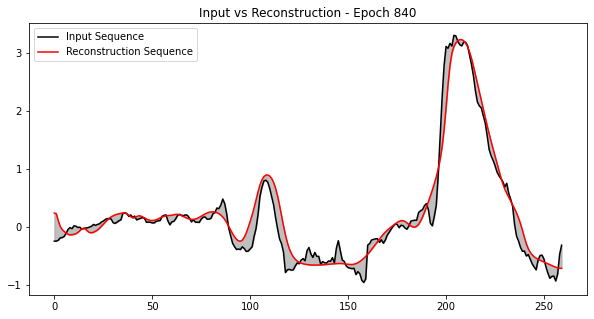

Epoch 841: train loss 56.74997655083151 val loss 54.48477231193991
Epoch 842: train loss 54.19667973237879 val loss 59.29771784614114
Epoch 843: train loss 60.81929624220904 val loss 62.033108565386605
Epoch 844: train loss 78.07570962344899 val loss 72.07626778097713
Epoch 845: train loss 72.55418086332433 val loss 67.27627736259909
Epoch 846: train loss 62.87671585083008 val loss 63.27567612143124
Epoch 847: train loss 60.007420438878675 val loss 62.06305728239172
Epoch 848: train loss 58.949796048332665 val loss 57.79671947254854
Epoch 849: train loss 56.613339188519646 val loss 56.93036649367389
Epoch 850: train loss 54.835012839822205 val loss 54.37863053714528
Epoch 851: train loss 55.35745679069968 val loss 60.91947499443503
Epoch 852: train loss 56.614660150864545 val loss 54.47108167760513
Epoch 853: train loss 56.337766445384304 val loss 62.05649122350356
Epoch 854: train loss 54.7726936564726 val loss 57.76709388284122
Epoch 855: train loss 58.67839853623334 val loss 70.6911

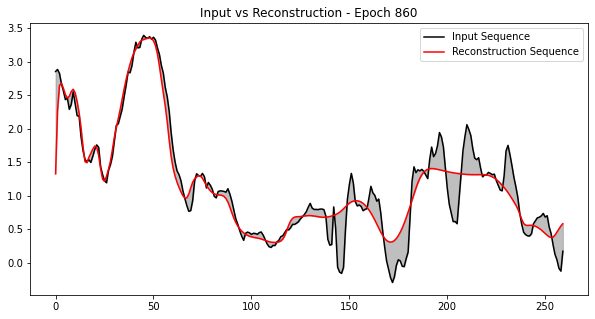

Epoch 861: train loss 59.391737792071176 val loss 60.35835692461799
Epoch 862: train loss 56.90903344995835 val loss 60.93628910289091
Epoch 863: train loss 57.05821302077349 val loss 68.58435094496784
Epoch 864: train loss 63.352312200209674 val loss 65.62519596324248
Epoch 865: train loss 60.003523411470304 val loss 59.81949155470904
Epoch 866: train loss 56.67691096137552 val loss 54.410696029663086
Epoch 867: train loss 55.23615504994112 val loss 60.62421246696921
Epoch 868: train loss 54.77758977553424 val loss 61.50495053459616
Epoch 869: train loss 59.44895728616154 val loss 57.05054792516372
Epoch 870: train loss 56.79745281443876 val loss 56.20884053847369
Epoch 871: train loss 57.970645837222825 val loss 57.53938807319192
Epoch 872: train loss 53.80558729732738 val loss 53.51490741056554
Epoch 873: train loss 53.74102718128878 val loss 58.89809343674604
Epoch 874: train loss 59.03759004929486 val loss 59.192813334745516
Epoch 875: train loss 55.620862399830536 val loss 53.397

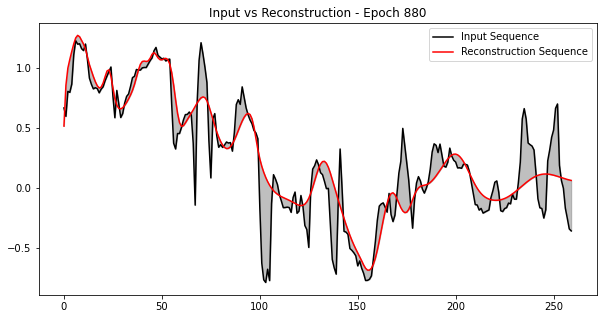

Epoch 881: train loss 59.24454204334932 val loss 62.254539085836974
Epoch 882: train loss 56.52107196134679 val loss 55.476433249080884
Epoch 883: train loss 53.05872407801011 val loss 61.565835863001205
Epoch 884: train loss 58.41278370127959 val loss 58.214064564424405
Epoch 885: train loss 59.28865912942325 val loss 68.95165679034065
Epoch 886: train loss 63.07057077744428 val loss 57.79030912062701
Epoch 887: train loss 57.897619539148664 val loss 55.44214807398179
Epoch 888: train loss 57.397640991210935 val loss 58.33238794663373
Epoch 889: train loss 56.04622968785903 val loss 55.31790096058565
Epoch 890: train loss 55.348516845703124 val loss 57.28609598945169
Epoch 891: train loss 54.81912283055922 val loss 53.518980901381546
Epoch 892: train loss 54.94463976691751 val loss 54.37900314331055
Epoch 893: train loss 55.82261085510254 val loss 55.167454618566175
Epoch 894: train loss 55.1119301964255 val loss 55.083047732184916
Epoch 895: train loss 56.73341751098633 val loss 62.4

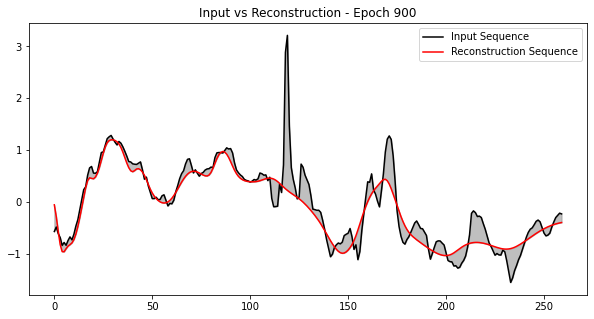

Epoch 901: train loss 58.69575233459473 val loss 57.84504717658548
Epoch 902: train loss 55.36624587563907 val loss 57.76114082336426
Epoch 903: train loss 56.07621731477625 val loss 56.4029863020953
Epoch 904: train loss 55.25321578979492 val loss 55.37640051000258
Epoch 905: train loss 54.253859486299405 val loss 61.3706220739028
Epoch 906: train loss 55.45028960284065 val loss 54.73244830860811
Epoch 907: train loss 54.936817460901594 val loss 68.82644835079418
Epoch 908: train loss 59.96173459221335 val loss 59.62104579701143
Epoch 909: train loss 58.70042753780589 val loss 63.132976778815774
Epoch 910: train loss 60.098510203642 val loss 55.92750706392176
Epoch 911: train loss 56.875437141867245 val loss 62.037295330272
Epoch 912: train loss 56.33472175598145 val loss 60.643203937306126
Epoch 913: train loss 60.13361513474408 val loss 60.28400540071375
Epoch 914: train loss 60.58798237968894 val loss 58.729590472053076
Epoch 915: train loss 58.891085725672106 val loss 62.487334823

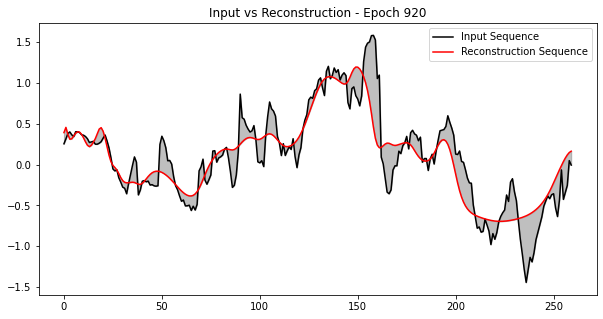

Epoch 921: train loss 58.04113289328183 val loss 59.11744521645939
Epoch 922: train loss 56.65073686487534 val loss 64.52617375990924
Epoch 923: train loss 59.64171607073616 val loss 57.02378172032974
Epoch 924: train loss 55.29811684103573 val loss 60.039178107766546
Epoch 925: train loss 58.34852220871869 val loss 58.68690223693848
Epoch 926: train loss 54.79645785163431 val loss 58.962538214290845
Epoch 927: train loss 56.65063377829159 val loss 57.042026497335996
Epoch 928: train loss 57.36955777336569 val loss 55.24712627635282
Epoch 929: train loss 53.93939298741958 val loss 59.124691256354836
Epoch 930: train loss 55.931162194644706 val loss 56.755284724516024
Epoch 931: train loss 55.98075938505285 val loss 60.80960222132066
Epoch 932: train loss 59.34640738543342 val loss 57.35099031784955
Epoch 933: train loss 54.087349902882295 val loss 55.162960837869086
Epoch 934: train loss 54.17978910558364 val loss 55.02945408540614
Epoch 935: train loss 54.3958527060116 val loss 54.585

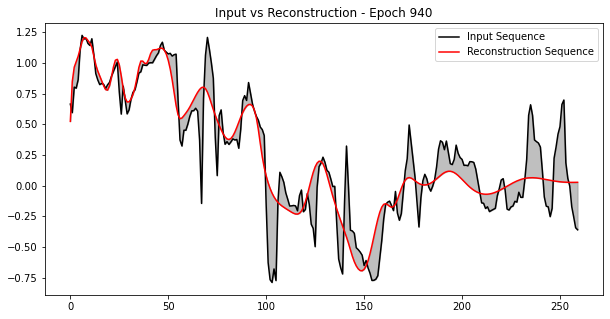

Epoch 941: train loss 57.276823761883904 val loss 65.42880967084099
Epoch 942: train loss 60.68758228526396 val loss 61.17059130949133
Epoch 943: train loss 67.67307582182043 val loss 89.95829627093147
Epoch 944: train loss 102.51080079920152 val loss 101.62358889860265
Epoch 945: train loss 102.40673991932589 val loss 90.20307004591999
Epoch 946: train loss 86.26751143511603 val loss 81.99681479510139
Epoch 947: train loss 81.51252715166878 val loss 81.95987914590275
Epoch 948: train loss 86.32883540882784 val loss 77.5606829699348
Epoch 949: train loss 82.41220480974982 val loss 71.71511371836942
Epoch 950: train loss 71.97459799822639 val loss 65.65056159075569
Epoch 951: train loss 74.6502639097326 val loss 74.77176560794607
Epoch 952: train loss 73.03366863026338 val loss 66.23126905104694
Epoch 953: train loss 65.62595358455883 val loss 61.72031752642463
Epoch 954: train loss 60.7788906770594 val loss 58.43018159305348
Epoch 955: train loss 59.74426729538862 val loss 64.476308441

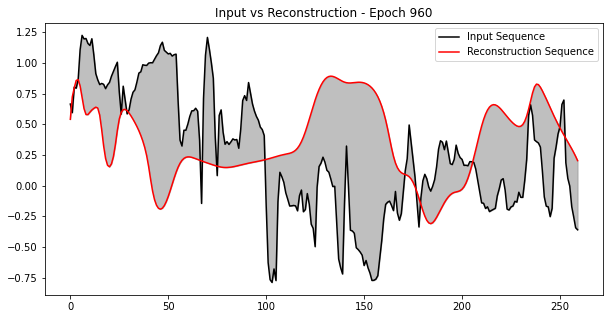

Epoch 961: train loss 120.60579739738913 val loss 125.1948501811308
Epoch 962: train loss 127.79308960858513 val loss 121.16483989042395
Epoch 963: train loss 121.44781238331514 val loss 116.65347918342141
Epoch 964: train loss 118.03487077600816 val loss 109.08436427396886
Epoch 965: train loss 110.08951214061064 val loss 105.9377862369313
Epoch 966: train loss 112.15821021584904 val loss 107.21457173964556
Epoch 967: train loss 106.19936379825367 val loss 98.79013016644646
Epoch 968: train loss 99.12702529009651 val loss 92.19120665157543
Epoch 969: train loss 92.63083956101362 val loss 87.12156742320342
Epoch 970: train loss 90.15447897069595 val loss 86.77929449642406
Epoch 971: train loss 86.29871096891516 val loss 85.3492187948788
Epoch 972: train loss 85.55930184757008 val loss 79.30320777893067
Epoch 973: train loss 81.02517002330107 val loss 79.71014646642348
Epoch 974: train loss 101.9371296153349 val loss 105.7389186634737
Epoch 975: train loss 101.81332704880658 val loss 89

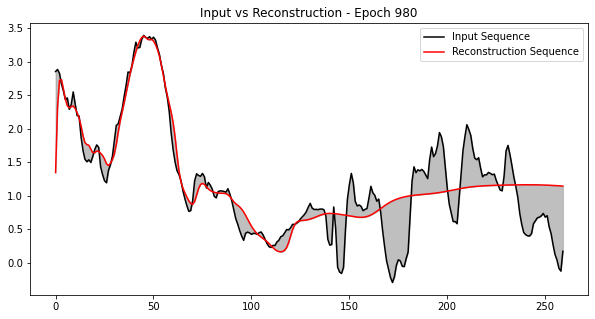

Epoch 981: train loss 76.51260106703815 val loss 73.25637819626752
Epoch 982: train loss 73.33884921354407 val loss 72.21073146146887
Epoch 983: train loss 72.88783416748046 val loss 71.74021023021025
Epoch 984: train loss 72.49822262034697 val loss 71.1726167566636
Epoch 985: train loss 72.76311838486615 val loss 71.89817166047938
Epoch 986: train loss 73.26478177238913 val loss 71.45378601971795
Epoch 987: train loss 76.61979540656594 val loss 73.33704750958611
Epoch 988: train loss 73.83958843455595 val loss 72.43166831521427
Epoch 989: train loss 75.86997512368595 val loss 70.46272589739631
Epoch 990: train loss 72.3216879900764 val loss 69.93614878934973
Epoch 991: train loss 68.15740802989286 val loss 65.73769695057588
Epoch 992: train loss 65.15046837750603 val loss 63.41918260910932
Epoch 993: train loss 62.230641062119425 val loss 64.88921914942124
Epoch 994: train loss 62.955389651130226 val loss 67.0704651776482
Epoch 995: train loss 63.923828506469725 val loss 62.0445202771

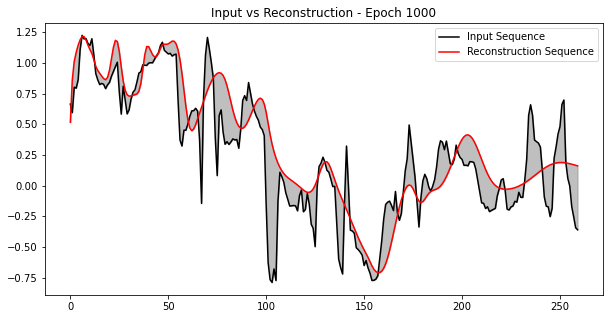

In [100]:
save_path = 'best_model.pth'  # Replace with your actual path
model, history = train_model(model, train_dataset, train_dataset, 1000, save_path)

In [67]:
model = Autoencoder(seq_len, n_features, 12)

model.load_state_dict(torch.load('best_model.pth'))

model = model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	size mismatch for encoder.rnn1.weight_ih_l0: copying a param with shape torch.Size([1152, 1]) from checkpoint, the shape in current model is torch.Size([96, 1]).
	size mismatch for encoder.rnn1.weight_hh_l0: copying a param with shape torch.Size([1152, 288]) from checkpoint, the shape in current model is torch.Size([96, 24]).
	size mismatch for encoder.rnn1.bias_ih_l0: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder.rnn1.bias_hh_l0: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder.rnn2.weight_ih_l0: copying a param with shape torch.Size([576, 288]) from checkpoint, the shape in current model is torch.Size([48, 24]).
	size mismatch for encoder.rnn2.weight_hh_l0: copying a param with shape torch.Size([576, 144]) from checkpoint, the shape in current model is torch.Size([48, 12]).
	size mismatch for encoder.rnn2.bias_ih_l0: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder.rnn2.bias_hh_l0: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for decoder.rnn1.weight_ih_l0: copying a param with shape torch.Size([576, 144]) from checkpoint, the shape in current model is torch.Size([48, 12]).
	size mismatch for decoder.rnn1.weight_hh_l0: copying a param with shape torch.Size([576, 144]) from checkpoint, the shape in current model is torch.Size([48, 12]).
	size mismatch for decoder.rnn1.bias_ih_l0: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for decoder.rnn1.bias_hh_l0: copying a param with shape torch.Size([576]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for decoder.rnn2.weight_ih_l0: copying a param with shape torch.Size([1152, 144]) from checkpoint, the shape in current model is torch.Size([96, 12]).
	size mismatch for decoder.rnn2.weight_hh_l0: copying a param with shape torch.Size([1152, 288]) from checkpoint, the shape in current model is torch.Size([96, 24]).
	size mismatch for decoder.rnn2.bias_ih_l0: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for decoder.rnn2.bias_hh_l0: copying a param with shape torch.Size([1152]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for decoder.output_layer.weight: copying a param with shape torch.Size([1, 288]) from checkpoint, the shape in current model is torch.Size([1, 24]).

In [132]:
len(train_dataset)

85

In [160]:
model.encoder.forward(train_dataset[0])

tensor([[ 0.0898,  0.0724,  0.2239,  0.0929, -0.1265,  0.1266,  0.0843, -0.0331,
          0.1386,  0.0523,  0.0249,  0.0664]], grad_fn=<ViewBackward0>)

In [271]:
model.eval()

Autoencoder(
  (encoder): Encoder(
    (rnn2): LSTM(1, 12, batch_first=True)
  )
  (decoder): Decoder(
    (rnn2): LSTM(12, 12, batch_first=True)
    (output_layer): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [97]:
labels = labels[:85]

In [ ]:
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming model and dataloader are already defined
model.eval()  # Set the model to evaluation mode

# Function to extract latent vectors
def get_latent_vectors(encoder, dataloader):
    with torch.no_grad():  # No need to track gradients
        latent_vectors = []
        for data in dataloader:
            inputs = data.to(device)  # Adjust depending on your dataloader structure
            latent = encoder(inputs)
            latent_vectors.append(latent.cpu().numpy())  # Move tensors to CPU and convert to numpy
    return np.concatenate(latent_vectors, axis=0)

# Assuming you have a DataLoader called dataloader
latent_vectors = get_latent_vectors(model.encoder, train_dataset)

# Dimensionality Reduction
pca = PCA(n_components=3)  # Reduce to 2 dimensions for plotting
latent_2d = pca.fit_transform(latent_vectors)

# Alternatively, using t-SNE for a more complex but possibly clearer visualization
# tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
# latent_2d = tsne.fit_transform(latent_vectors)

# Plotting
plt.figure(figsize=(10, 6))
for label, color in label_to_color.items():
    idx = labels == label
    plt.scatter(latent_2d[idx, 2], latent_2d[idx, 1], color=color, label=str(label), alpha=0.7, edgecolors='w', s=60)
plt.title('Latent Space Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.legend(title='Labels')
plt.show()

In [268]:
len(train_dataset)

85

In [95]:
# Define a colormap for the labels
unique_labels = np.unique(labels[:100])
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))  # Use jet colormap or choose another
label_to_color = dict(zip(unique_labels, colors))


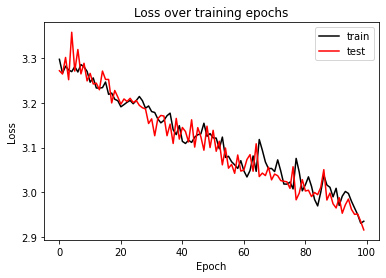

In [248]:
ax = plt.figure().gca()

ax.plot(history['train'],label='Train Loss', color='black')
ax.plot(history['val'],label='Val Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

### ECG Anomaly Detection Model Evaluation and Visualization in PyTorch

The code in this section performs the evaluation and visualization stages for an ECG anomaly detection model using PyTorch. It focuses on assessing the model's ability to differentiate between normal and anomalous ECG sequences and visually representing its predictions.

1. **Model Loading and Preparation**:
    - The pre-trained Autoencoder model is loaded with its optimal weights from a saved state, ensuring it is ready for evaluation.
    - The model is transferred to the appropriate device (GPU/CPU) and set to evaluation mode.

2. **Prediction Function**:
    - `predict` is a function designed to process a dataset through the model, computing the reconstruction loss for each sequence.
    - It outputs both the reconstructed sequences and their corresponding losses, which are crucial metrics for evaluating the model's performance.

3. **Loss Distribution Visualization**:
    - The reconstruction losses for the training dataset are visualized using a distribution plot, providing insight into the model's performance during training.
    - A threshold (25 in this case) is set to differentiate between normal and anomalous readings based on the loss.

4. **Model Performance on Test Data**:
    - The model's effectiveness is tested on a 'normal' test dataset, with the distribution of reconstruction losses plotted. This helps in understanding how the model performs on unseen but normal ECG data.
    - The number of correctly identified normal sequences is calculated and displayed, offering a quantitative measure of performance.

5. **Anomaly Detection and Visualization**:
    - The model is then evaluated on an 'anomaly' dataset to test its ability to identify anomalies.
    - A distribution plot for the losses on the anomaly dataset is created, with anomalies expected to have higher reconstruction losses.
    - The number of correctly identified anomalies is calculated, providing a metric for the model's sensitivity to abnormalities.

6. **Individual Predictions Visualization**:
    - `plot_prediction` is a function that visualizes the original and reconstructed ECG sequences, along with their reconstruction loss. This visualization is instrumental in understanding the model's performance on an individual sequence level.
    - The script creates a series of plots for both normal and anomalous ECG sequences from the test datasets, allowing for a direct visual comparison of the model's predictions against the actual data.

This comprehensive evaluation and visualization approach enables a thorough understanding of the model's capabilities and limitations in real-world scenarios. It offers an in-depth analysis of how effectively the model can identify and distinguish between normal and anomalous ECG patterns, which is critical for its application in healthcare monitoring systems.

In [250]:
model = Autoencoder(seq_len, n_features, 36)

model.load_state_dict(torch.load('best_model.pth'))

model = model.to(device)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (rnn2): LSTM(1, 36, batch_first=True)
  )
  (decoder): Decoder(
    (rnn2): LSTM(36, 72, batch_first=True)
    (output_layer): Linear(in_features=72, out_features=1, bias=True)
  )
)

In [348]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

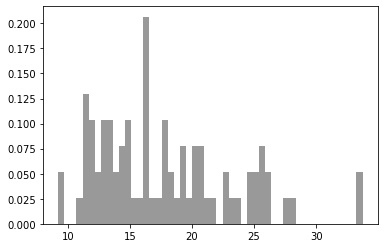

In [349]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True, label='Train',color='black');

#Visualising train loss

In [350]:
Threshold = 25

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

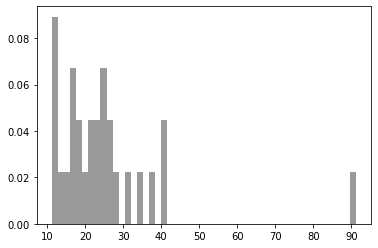

In [351]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='black');

In [352]:
correct = sum(l <= 25 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 18/28


In [353]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]


In [354]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True,color='red');


RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

In [355]:
correct = sum(l > 25 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 10/28


In [356]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true',color='black')
  ax.plot(predictions[0], label='reconstructed',color='red')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

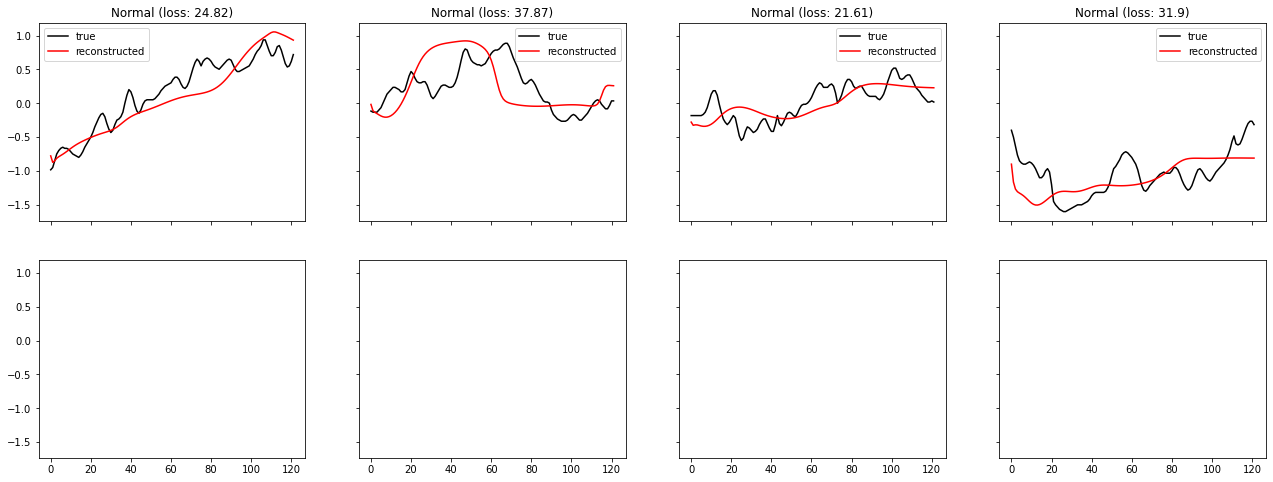

In [357]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

RuntimeError: shape '[1, 122, 1]' is invalid for input of size 140

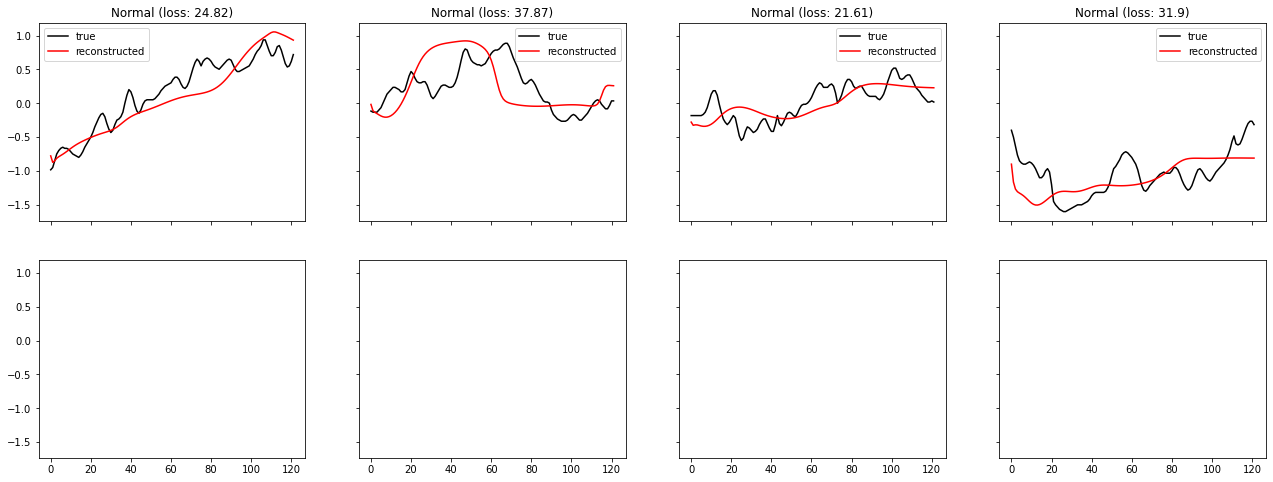

In [358]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=4,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:4]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:4]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();